#### Описание задачи

- Подробное описание в файле gpn-cup-2021-data_science_task.docx

Для увеличения продаж товаров из следующих групп:
- вода
- сладкие газированные напитки, холодный чай
- кофейные напитки с молоком
- энергетические напитки
- снеки
- соки и сокосодержащие напитки  

Вам необходимо разработать рекомендательную систему, которая будет предлагать покупателям 20 дополнительных товаров в чек.  

Пример: покупатель приходит на кассу с 2-мя товарами: напитком «Local-Cola» и чипсами «Sya'l». Алгоритм должен предложить 20 товаров, которые пользователь вероятнее всего захочет добавить в свою корзину (в порядке убывания релевантности). На практике кассир предложит 1й по порядку товар, из имеющихся в наличии. 
В качестве метрики качества рекомендаций используется mean average precision at 20

Транзакционные данные продаж – transactions:
- sku_id – уникальный идентификатор товара
- price – цена, по которой был продан товар
- number – количество товаров (если не топливо) 
- cheque_id – уникальный идентификатор чека
- litrs – количество литров (если товар - топливо)
- client_id – уникальный идентификатор клиента (если клиент «представился» при покупке)
- shop_id – уникальный идентификатор магазина
- date – дата транзакции  

Данные о товарах – nomenclature:
- sku_id – уникальный идентификатор товара
- full_name – полное наименование товара
- brand – наименование торговой марки
- sku_group – группа, к которой принадлежит товар
- OTM – признак собственной торговой марки
- units – единица измерения для количества 
- country – страна производства товара  

Формат всех источников - .parquet.

In [1]:
#! pip install pyarrow

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sps

from tqdm import tqdm
import re 
import random

import implicit
import itertools
import pickle

%matplotlib inline

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Загрузка данных

In [65]:
df_trans = pd.read_parquet("Data/transactions.parquet")

In [66]:
df_nomencl = pd.read_parquet("Data/nomenclature.parquet")

#### Работа с пропусками, дублями и типами данных

- Транзакции

In [67]:
df_trans.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [68]:
#возьму конкретного клиента и посмотрю его чеки
#добавлю описание товаров из таблицы с номенклатурой
pd.merge(df_trans[df_trans['client_id'] == 96397], df_nomencl,
         on="sku_id").sort_values(by='date').head(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
18,1913,0.007337,0.000452,2634308,0.104183,96397.0,79,2171-03-07,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
31,1158,0.002301,0.000000,2634308,0.110832,96397.0,79,2171-03-07,None,None,Ethereum 92,None,None,None
16,1913,0.007337,0.000452,1817242,0.104183,96397.0,36,2171-03-14,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
30,1158,0.002306,0.000000,1817242,0.117461,96397.0,36,2171-03-14,None,None,Ethereum 92,None,None,None
17,1913,0.007337,0.000452,1817242,0.104183,96397.0,36,2171-03-14,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown


??? Почему у сигарет литры и numbers одновременно? numbers маленькие?

??? Есть ли где то литры = 0 или меньше 0?  
Есть значения unknown  

Разберусь с этим позже, сначала закончу с пропусками

<br>Пропуски

In [69]:
df_trans.isnull().sum()

sku_id             0
price              0
number             0
cheque_id          0
litrs              0
client_id    3772355
shop_id            0
date               0
dtype: int64

In [70]:
#посмотрю на несколько пропусков
df_trans[df_trans['client_id'].isna()].head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
11,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
12,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
13,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
14,1158,0.002335,0.000000,2582618,0.115122,NaN,103,2171-07-23
16,1158,0.002335,0.000000,3338268,0.126051,NaN,102,2171-07-23


client_id имеет много пропусков, нам об это и сказали в условии задачи (уникальный идентификатор клиента заполнен если клиент "представился" при покупке. Под представился вероятно имеется в виду наличие карты лояльности). Заменю таких клиентов на "-1"

In [71]:
df_trans['client_id'] = df_trans['client_id'].fillna(-1)

In [72]:
df_trans.isnull().sum()

sku_id       0
price        0
number       0
cheque_id    0
litrs        0
client_id    0
shop_id      0
date         0
dtype: int64

<br><br>Типы данных

In [73]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


 Все ок, за исключением client_id, почему то у него тип float а по логике должен быть int

In [74]:
#посмотрю на дробные части, есть ли что то отличное от нуля?
client_id_parts = []
for val in df_trans["client_id"].values:
    client_id_parts.append(str(val).split(".")[1])

In [75]:
#дробная часть всегда равна нулю. 
#Переделаю тип в int
set(client_id_parts)

{'0'}

In [76]:
df_trans['client_id'] = df_trans['client_id'].astype(int)

<br><br>Удаление дублей

In [77]:
print("Записей до удаления дубликатов: {}".format(len(df_trans)))

Записей до удаления дубликатов: 7620119


In [78]:
df_trans.drop_duplicates(subset=None, keep='first', inplace=True)

In [79]:
print("Записей после удаления дубликатов: {}".format(len(df_trans)))

Записей после удаления дубликатов: 6800919


Сколько у нас трназакций по времени?

In [80]:
#для начала отсротирую данные по дате
df_trans = df_trans.sort_values(by='date')

In [81]:
df_trans.head(1)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
7620118,1158,0.00227,0.0,1764664,0.159197,192548,77,2171-03-01


In [82]:
df_trans.tail(1)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
40967,1509,0.008671,0.000452,2625142,0.104183,-1,6,2171-07-31


Данные у нас за 5 месяцев.  
Визуализирую количество чеков по месяцам, чтобы понять активность или просадки в данных или продажах

In [83]:
#Создам столбец с месяцем
df_trans['month'] = df_trans['date'].apply(lambda d: d.month)

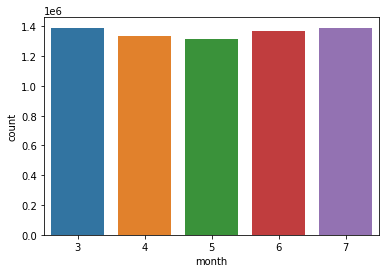

In [84]:
sns.countplot(data=df_trans, x='month');

В целом количество чеков, суммарно по всем заправкам, +/- одинаковая в разрезе месяцев, нет падений или явного отсутствия данных.

- #### Номенклатура

In [85]:
df_nomencl.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


Типы данных

In [86]:
df_nomencl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5094 non-null   object
 2   brand      5094 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5094 non-null   object
 5   units      5094 non-null   object
 6   country    5094 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


Все ок с типами данных

<br><br>Такого рода переменные следует удалить:
- переменных, у которых количество категорий совпадает с количеством наблюдений
- переменных с одним уникальным значением
- переменных констант  
В наших данных такого нет.

<br><br>Пропуски

In [87]:
#где пропуски?
df_nomencl.isnull().sum()

sku_id       0
full_name    9
brand        9
sku_group    0
OTM          9
units        9
country      9
dtype: int64

In [88]:
nan_values_index = [] #сохраню индексы строк с пропусками

for col in df_nomencl.columns:
    nan_values_index = [*nan_values_index, 
                        *df_nomencl[df_nomencl[col].isna()].index.values]
    
nan_values_index = list(set(nan_values_index))

In [89]:
#выделю в отдельный dataframe все строки с пропусками в номенклатуре чтобы проанализировать их
df_nomencl_nan = df_nomencl.loc[nan_values_index] #все строки с пропусками

nan_values_sku_id = df_nomencl_nan['sku_id'].values #sku_id товаров с пропусками
nan_values_ethereum_sku_id = df_nomencl_nan[df_nomencl_nan['sku_group'].str.contains('Ethereum')]\
                            ['sku_id'].values#sku_id товаров из тех что имеют пропуски и содержащих *Ethereum*
nan_values_varpfuel_sku_id = df_nomencl_nan[df_nomencl_nan['sku_group'].str.contains('варповое')]\
                            ['sku_id'].values#sku_id товаров из тех что имеют пропуски и содержащих *варповое*

df_nomencl_nan

,sku_id,full_name,brand,sku_group,OTM,units,country
3787,1159,None,None,Ethereum 95,None,None,None
3724,1158,None,None,Ethereum 92,None,None,None
3727,1157,None,None,Ethereum 95 бренд,None,None,None
3728,1163,None,None,Топливо варповое с присадками летнее,None,None,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,None,None
3858,2032,None,None,Ethereum 100 бренд,None,None,None
4407,1161,None,None,Топливо варповое летнее,None,None,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,None,None
3771,1160,None,None,Топливо варповое зимнее,None,None,None


Все 9 столбцов с пропусками в 9 записях. Отсутствует все кроме наименования. По группе видно что все товары это топливо. 
Не смотря на то, что в условии задачи нет категорий с топливом для которых нужно предложить следующий товар, может существовать связь между топливом и напитками или другими товарами, ведь люди приезжают за топливом на заправку. 

Нужно восстановить пропущенные значения.

Очевидно, что эти товары топливо.  
Можно проверить по таблице с транзакциями, товар-топливо это если number=0 а litrs>0

In [90]:
_ = df_trans[df_trans['sku_id'].isin(nan_values_sku_id)]
_.groupby('sku_id')[['number', 'litrs']].sum()

,number,litrs
sku_id,,
1157,0.0,46769.789831
1158,0.0,64796.547015
1159,0.0,85426.704022
1160,0.0,557.685280
1161,0.0,6.378492
1162,0.0,15609.847960
1163,0.0,24803.053550
1771,0.0,109.060796
2032,0.0,15628.749112


Как видно, numbers = 0 а litrs - числа, значит units = 'л'

In [91]:
#проставляю для этих пропусков литры
df_nomencl.at[nan_values_index, 'units'] = 'л'

- Посмотрю на товары с пропусками и соджержащие слово Ethereum:

In [92]:
df_nomencl[df_nomencl['sku_group'].str.contains('Ethereum')]

,sku_id,full_name,brand,sku_group,OTM,units,country
549,610,Масло GAZPROMNEFT моторное М-8В 1л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,unknown
550,622,Масло GAZPROMNEFT Super 10W-40 1л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
551,617,Масло GAZPROMNEFT Super 10W-40 API SG/CD 4л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
552,614,Масло GAZPROMNEFT Premium L 10W-40 API SL/CF A...,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
553,609,Масло G-Energy F Synth 5W-40 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
554,2653,Масло G-Energy F Synth 5W-40 4л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
555,612,Масло G-Energy S Synth 10W-40 IT 4л,G-Energy,Масла моторные (для Ethereumовых двигателей),Нет,л,ИТАЛИЯ
556,1595,Масло G-Energy F Synth EC 5W-30 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
557,606,Масло G-Energy F Synth 5W-30 A3/B4 4л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
558,615,Масло G-Energy S Synth 10W-40 IT 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ


Выводы:
- По описанию товаров, Ethereum = бензин
- Цифра после Ethereum это октановое число и качество бензина
- Слово "бренд" в товарах с пропусками и содержащие Ethereum, полагаю означает brand=G-Energy, иначе brand=GAZPROMNEFT
- Есть строка с моторным маслом, где в столбце units стоит unknown, хотя должно быть "л", похоже такие записи так же нужно отнести к пропускам и поработать с ними отдельно

In [93]:
#sku_id товаров из тех что имеют пропуски и содержащих *Ethereum*
nan_values_ethereum_sku_id

array([1159, 1158, 1157, 2032])

In [94]:
#индексы строк бензина с пропусками brand=G-Energy
genergy_ethereum_index =\
            df_nomencl[(df_nomencl['sku_id'].isin(nan_values_ethereum_sku_id)) &
           (df_nomencl['sku_group'].str.contains('бренд'))].index.values

In [95]:
#индексы строк бензина с пропусками brand=GAZPROMNEFT
gpn_ethereum_index =\
             df_nomencl[(df_nomencl['sku_id'].isin(nan_values_ethereum_sku_id)) &
           (~df_nomencl['sku_group'].str.contains('бренд'))].index.values

In [96]:
#проставляю бренд для бензнина с пропусками
df_nomencl.at[genergy_ethereum_index, 'brand'] = 'G-Energy'
df_nomencl.at[gpn_ethereum_index, 'brand'] = 'GAZPROMNEFT'

In [97]:
#проставляю в full_name для бензнина с пропусками данные из категории
#а категорию сделаю "Топливо Ethereum"
for ethereum_sku_id in nan_values_ethereum_sku_id:
    row = df_nomencl[df_nomencl['sku_id']==ethereum_sku_id]
    df_nomencl.at[row.index, 'full_name'] = row['sku_group']
    df_nomencl.at[row.index, 'sku_group'] = "Топливо Ethereum"

Посмотрю на страны производства брендов 'GAZPROMNEFT' и 'G-Energy':

In [98]:
df_nomencl[df_nomencl['brand'].isin(['GAZPROMNEFT','G-Energy'])].\
            groupby(['brand','country','sku_group'])['country'].count().unstack().fillna(0)

sku_group            Автохимия и автокосметика (кроме масел, смазок и СОЖ)  \
brand       country                                                          
G-Energy    ИТАЛИЯ                                                 4.0       
            РОССИЯ                                                 2.0       
GAZPROMNEFT unknown                                                2.0       
            ИТАЛИЯ                                                 0.0       
            РОССИЯ                                                 0.0       

sku_group            Масла моторные (для Ethereumовых двигателей)  \
brand       country                                                 
G-Energy    ИТАЛИЯ                                            1.0   
            РОССИЯ                                            2.0   
GAZPROMNEFT unknown                                           0.0   
            ИТАЛИЯ                                            0.0   
            РОССИЯ                                            0.0   

sku_group            Масла моторные (для Ethereumовых двигателей) "УранПромEtherium"  \
brand       country                                                                    
G-Energy    ИТАЛИЯ                                                 7.0                 
            РОССИЯ                                                 0.0                 
GAZPROMNEFT unknown                                                2.0                 
            ИТАЛИЯ                                                 0.0                 
            РОССИЯ                                                10.0                 

sku_group            Масла моторные (для варповых двигателей)"УранПромEtherium"  \
brand       country                                                               
G-Energy    ИТАЛИЯ                                                 0.0            
            РОССИЯ                                                 0.0            
GAZPROMNEFT unknown                                                1.0            
            ИТАЛИЯ                                                 0.0            
            РОССИЯ                                                 3.0            

sku_group            Масла прочие "УранПромEtherium"  \
brand       country                                    
G-Energy    ИТАЛИЯ                               0.0   
            РОССИЯ                               0.0   
GAZPROMNEFT unknown                              1.0   
            ИТАЛИЯ                               0.0   
            РОССИЯ                               2.0   

sku_group            Масла трансмиссионные "УранПромEtherium"  \
brand       country                                             
G-Energy    ИТАЛИЯ                                        0.0   
            РОССИЯ                                        0.0   
GAZPROMNEFT unknown                                       1.0   
            ИТАЛИЯ                                        0.0   
            РОССИЯ                                        1.0   

sku_group            Смазки пластичные "УранПромEtherium"  
brand       country                                        
G-Energy    ИТАЛИЯ                                    0.0  
            РОССИЯ                                    0.0  
GAZPROMNEFT unknown                                   0.0  
            ИТАЛИЯ                                    1.0  
            РОССИЯ                                    0.0

- GAZPROMNEFT - производится в основном в России, есть несколько unknown, полагаю что это тоже Россия.  
- G-Energy - больше в Италии.  
Сейчас речь идет про бензин, очень низкая вероятность что его привозят из-за границы, было бы очень дорого, буду считать что для бензина обоих брендов страна производитель будет Россия. Тем более если брать ГПН то это так.


In [99]:
#проставляю страну для бензнина с пропусками
df_nomencl.at[genergy_ethereum_index, 'country'] = 'РОССИЯ'
df_nomencl.at[gpn_ethereum_index, 'country'] = 'РОССИЯ'

- товары с пропусками содержащие "варповое"

In [100]:
df_nomencl[df_nomencl['sku_group'].str.contains('варповое')]

,sku_id,full_name,brand,sku_group,OTM,units,country
3728,1163,None,None,Топливо варповое с присадками летнее,None,л,None
3771,1160,None,None,Топливо варповое зимнее,None,л,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,л,None
4407,1161,None,None,Топливо варповое летнее,None,л,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,л,None


Полагаю что это дизельное топливо, пропишу бренд=GAZPROMNEFT, страна=Россия

In [101]:
nan_values_varpfuel_index = df_nomencl[df_nomencl['sku_id'].isin(nan_values_varpfuel_sku_id)].index.values

In [102]:
#проставляю страну для дизеля с пропусками
df_nomencl.at[nan_values_varpfuel_index, 'country'] = 'РОССИЯ'

In [103]:
#проставляю в full_name для дизельного топлива с пропусками данные из категории
#а категорию сделаю "Топливо варповое"
for sku_id in nan_values_varpfuel_sku_id:
    row = df_nomencl[df_nomencl['sku_id'] == sku_id]
    df_nomencl.at[row.index, 'full_name'] = row['sku_group']
    df_nomencl.at[row.index, 'sku_group'] = "Топливо варповое"

In [104]:
#проставляю бренд для дизеля с пропусками
df_nomencl.at[nan_values_varpfuel_index, 'brand'] = 'GAZPROMNEFT'

In [105]:
df_nomencl[df_nomencl['sku_group'].str.contains('варповое')]

,sku_id,full_name,brand,sku_group,OTM,units,country
3728,1163,Топливо варповое с присадками летнее,GAZPROMNEFT,Топливо варповое,None,л,РОССИЯ
3771,1160,Топливо варповое зимнее,GAZPROMNEFT,Топливо варповое,None,л,РОССИЯ
3825,1162,Топливо варповое с присадками зимнее,GAZPROMNEFT,Топливо варповое,None,л,РОССИЯ
4407,1161,Топливо варповое летнее,GAZPROMNEFT,Топливо варповое,None,л,РОССИЯ
4922,1771,Топливо варповое с присадками межсезонное,GAZPROMNEFT,Топливо варповое,None,л,РОССИЯ


Что с OTM (признак собственной торговой марки)?

In [106]:
df_nomencl['OTM'].value_counts()

Нет        3336
unknown    1370
Да          388
Name: OTM, dtype: int64

В нем очень много много пропусков(unknown), и в целом столбец не кажется информативным и полезным, возможно не буду его использовать.  
Для топлива выставлю - "Да".

In [107]:
#проставляю признак собственного бренда "Да"
df_nomencl.at[nan_values_index, 'OTM'] = 'Да'

<br><br>Удаление дубликатов в номенклатуре

In [108]:
print("Записей до удаления дубликатов: {}".format(len(df_nomencl)))

Записей до удаления дубликатов: 5103


In [109]:
df_nomencl.drop_duplicates(subset=None, keep='first', inplace=True)

In [110]:
print("Записей после удаления дубликатов: {}".format(len(df_nomencl)))

Записей после удаления дубликатов: 5103


<br><br>Обработка редких категорий  

Если существуют редкие категории, то это может означать например что возможна опечатка или категория не из этого набора данных

In [111]:
#категориальные переменные, кроме "full_name"
nomencl_cat_cols = df_nomencl.select_dtypes(include=['object']).columns.to_list()
nomencl_cat_cols.remove("full_name")
nomencl_cat_cols

['brand', 'sku_group', 'OTM', 'units', 'country']

- brand

In [112]:
#посмотрим на количество товаров для брендов
df_brand = df_nomencl['brand'].value_counts().sort_values(ascending=True).reset_index()
df_brand

,index,brand
0,КИРИЕШКИ,1
1,Сытоедов,1
2,Nerf,1
3,КУЗЯ Лакомкин,1
4,Тройка,1
...,...,...
495,G-Fly (СТМ),129
496,УранПРОМEthereum,130
497,SAPFIRE,159
498,Fly Cafe,255


Много брендов с только одним товаром, посмотрю на них подробнее.

In [113]:
brands_1sku = df_brand[df_brand["brand"] == 1]["index"].values
brands_1sku.sort() #бренды с одним товаром, сортирую по имени чтобы смотреть опечатки (буду делать визуально, данных не много)
brands_1sku

array(['7D', 'AROMA TOP LINE', 'ASCANIA', 'AVIORA', 'AdBlue', 'Albeni',
       'Always', 'BAIKAL', 'BEERka', 'BIO MAX', 'BIOCOS',
       'Baikal Reserve', 'Barilla', 'Barinoff', 'Blend-a-med',
       'CONFASHON', 'Cafe Creme', 'Clausthaler', 'Colts', 'DOUBLEMINT',
       'Delifrance', 'Dr.Pepper', 'Dunhill', 'EVE', 'Evitest',
       'FIFA-2018', 'FLAMECLUB', 'FORSITE', 'Fazer', 'Filipino Sun',
       "FinSya'lon", 'G-Box', 'GEISHA', 'GEOVITA', 'Gatorade',
       'Greenfield', 'Head&Shoulders', 'Heineken', 'IRN BRU', 'IRONMAN',
       'Laimon orange', 'Lantmannen Unibake', 'Lenco', 'Logic Compact',
       'Lollipops', 'MAXIBON', 'Magic Pet Beads', 'Maltesers',
       'Me to You', 'Medovarus', 'Moon Berry', 'Morning Care',
       'Mountain DEW', 'NOVA Bright', 'Naturella', 'Nerf', 'Nestle',
       'Notpil', 'Ola!', 'Old Spice', 'PAW Patrol', 'POWERADE', 'PRO',
       'Parmalat', 'Paw Patrol', 'Pepero', 'Pocky', 'Premial', 'REGNUM',
       'Ranaplast', 'Redex', 'Rohaus', 'Rondo', 'SPARTA'

Просмотрел визуально, опечаток не увидел.

Вообще сколько покупают товаров этих брендов?

In [114]:
skuid_brands_1sku = df_nomencl[df_nomencl["brand"].isin(brands_1sku)]["sku_id"].values
skuid_brands_1sku #ид товаров с брендом представленным только одним товаром

array([ 118,  424, 1711,  364, 4254, 1455,  949, 1256, 2194,  664, 2010,
       1795, 3101, 3644, 2108,  287, 1055, 1582,   93, 1122, 4647,  435,
         14, 4509, 2835,  857,  152, 2227, 4314,  500,  471, 4634, 4411,
       1396, 3947, 5085, 4163, 3313,   17, 1433,  626, 2796, 1121,   41,
        506,  766, 4285,  963, 2904, 1008, 4961, 4963, 2068, 2463,  535,
       1924,  577, 1094, 4164, 2516, 3528,  958,   87,  452, 4070,   10,
       1892, 3573, 3994,  822, 1593, 3721,    7,  537, 3133, 1943,  399,
       3509, 2449, 1564, 2460, 3192, 2918,  549, 3071, 1936, 2953, 3050,
       1927, 1671, 1247, 2773, 4128, 3722,  519, 4878, 2492, 3128,  125,
       3257, 2386,  178, 4690, 1938,   23,  410, 2301, 1472, 2114, 4909,
       2916, 2939, 3177, 2667, 2164, 4245, 2532, 2149,  597, 3119, 2507,
        542,   59, 2940, 1102, 2848, 2474, 3546, 1132, 1862])

In [115]:
print("Доля покупаемых товаров бренд которых представлен только одним товаром:\
      {:.2f}%".format((len(df_trans[df_trans['sku_id'].isin(skuid_brands_1sku)])/len(df_trans))*100))

Доля покупаемых товаров бренд которых представлен только одним товаром:      3.36%


Не так то часто такие товары покупают, т.е. товары достаточно редкие, "на ценителя" или по необходимости, возможно их стоит в дальнейшем исключить из данных для обучения, хотя и так у них рейтинг будет низкий для попадания в рекомендации. Можно будет еще посмотреть в разрезе конкретных заправок, возможно где то это популярный товар.

In [116]:
brands_sku = df_brand[df_brand["brand"] != 1]["index"].values
brands_sku.sort() #бренды с несколькими товарами
#brands_sku

Опечатки в категориях можно поискать с помощью CountVectorizer или word2vec, найдя похожие слова и просмотрев их. Но данных не так много, для экономии времени просмотрел глазами.

c unknown по всем записям буду разбираться позже.

- sku_group

In [117]:
#df_nomencl['sku_group'].value_counts().sort_values(ascending=True).reset_index()

Просмотрел глазами, все ок.

- OTM

In [118]:
df_nomencl['OTM'].value_counts().sort_values(ascending=True).reset_index()

,index,OTM
0,Да,397
1,unknown,1370
2,Нет,3336


 - units

In [119]:
df_nomencl['units'].value_counts().sort_values(ascending=True).reset_index()

,index,units
0,м,3
1,кг,33
2,мл,45
3,л,706
4,г,1182
5,шт,1416
6,unknown,1718


Возможно стоит объединить в одни единицы "мл" и "л" а так же "кг" и "г", подумаю об этом позже, если такое потребуется.

- country

In [120]:
#df_nomencl['country'].value_counts().sort_values(ascending=True).reset_index()

Все ок

#### Разберусь с тем, что в некоторых транзакциях и litrs и number

Выше обнаружил такой нюнс, хотя по условию сказано, что number только не у топлива, а litrs у топлива.  
С топливом уже определил, что все ок, есть litrs и number=0.

In [122]:
df_trans_litrs_error = df_trans[(df_trans['number'] > 0) & (df_trans['litrs'] > 0)]
df_trans_litrs_error

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
7585450,3324,0.006106,0.000452,2262585,0.104183,345359,96,2171-03-01,3
7585449,3324,0.006106,0.000452,2262672,0.104183,66311,96,2171-03-01,3
7585448,3324,0.006106,0.000452,1764707,0.104183,352887,77,2171-03-01,3
7585447,417,0.008107,0.000452,3289368,0.104183,179887,102,2171-03-01,3
7585446,840,0.010723,0.000452,411166,0.104183,-1,23,2171-03-01,3
...,...,...,...,...,...,...,...,...,...
41343,964,0.010005,0.000452,2810661,0.104183,54091,17,2171-07-31,7
41342,530,0.003284,0.000452,3121460,0.104183,223337,33,2171-07-31,7
41340,1802,0.007132,0.000452,1138882,0.104183,221920,71,2171-07-31,7
41338,2674,0.007645,0.000452,2584535,0.104183,271639,103,2171-07-31,7


Довольно много записей с такой проблемой, уже видно, что litrs = 0.104183, проверю.

In [123]:
df_trans_litrs_error.litrs.value_counts()

0.104183    4975751
Name: litrs, dtype: int64

In [124]:
#Заменю такие значения на 0
df_trans.at[df_trans_litrs_error.index, 'litrs'] = 0

In [127]:
#больше таких значений не осталось
df_trans[(df_trans['number'] > 0) & (df_trans['litrs'] > 0)]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month


А есть отрицательные значения?

In [128]:
df_trans.describe()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,month
count,6.800919e+06,6.800919e+06,6.800919e+06,6.800919e+06,6.800919e+06,6.800919e+06,6.800919e+06,6.800919e+06
mean,1.555864e+03,6.219259e-03,3.811301e-04,1.642932e+06,3.730493e-02,1.056301e+05,5.021314e+01,5.004786e+00
std,1.144436e+03,7.282466e-03,2.363650e-03,1.004861e+06,6.236737e-02,1.318555e+05,3.184977e+01,1.425986e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,3.000000e+00
25%,8.340000e+02,2.637250e-03,0.000000e+00,7.217970e+05,0.000000e+00,-1.000000e+00,2.000000e+01,4.000000e+00
50%,1.159000e+03,5.592612e-03,4.522493e-04,1.628225e+06,0.000000e+00,1.920000e+04,4.400000e+01,5.000000e+00
75%,2.225000e+03,8.619805e-03,4.522493e-04,2.523205e+06,1.149930e-01,2.053810e+05,7.800000e+01,6.000000e+00
max,5.058000e+03,1.000000e+00,1.000000e+00,3.407195e+06,1.000000e+00,4.052290e+05,1.100000e+02,7.000000e+00


По min значениям видно, что отрицательных данных нет, кроме ид клиента, которые я сам заменил на "-1".

#### <br><br>Поиск выбросов

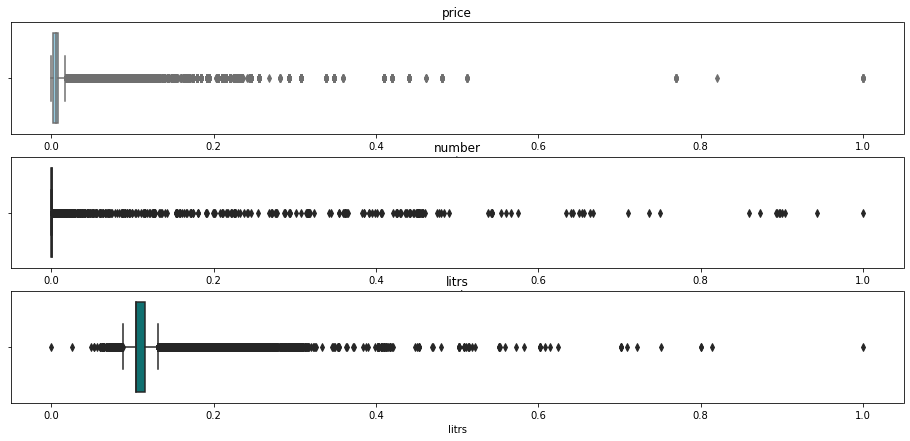

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(16, 7))

axs[0].set_title("price")
axs[1].set_title("number")
axs[2].set_title("litrs")
sns.boxplot(data=df_trans, x="price", color="skyblue", ax=axs[0])
sns.boxplot(data=df_trans, x="number", color="olive", ax=axs[1])
sns.boxplot(data=df_trans, x="litrs", color="teal", ax=axs[2])

plt.show()

Очевидно, что есть данные похожие на выбросы, во всех числовых переменных, много значений за межквартильным размахом и требуют доп анализа.

- price

In [134]:
df_trans.price.describe()

count    6.800919e+06
mean     6.219259e-03
std      7.282466e-03
min      0.000000e+00
25%      2.637250e-03
50%      5.592612e-03
75%      8.619805e-03
max      1.000000e+00
Name: price, dtype: float64

Есть цены менше нуля?

In [130]:
df_trans[df_trans["price"] < 0]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month


Посмотрим на товары с высокими ценами

In [143]:
df_trans_top_price = pd.merge(df_trans[df_trans["price"] > 0.4], 
                              df_nomencl,
                              on="sku_id").sort_values(by='cheque_id')

df_trans_top_price.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,brand,sku_group,OTM,units,country
108,4416,0.420215,0.000452,2332,0.0,399588,5,2171-03-15,3,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
101,4416,0.420215,0.000452,6562,0.0,23682,68,2171-03-03,3,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
92,4417,0.769112,0.000452,7281,0.0,354341,68,2171-03-04,3,Часы Swiss OAK SOW-01 36мм белые,Swiss OAK,"Хозяйственные товары, персональный уход",Нет,шт,КИТАЙ
2,4412,0.481786,0.000452,9396,0.0,102401,68,2171-03-07,3,Сумка FlyR TS5 TUBUS универсальная,FlyR,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
106,4416,0.420215,0.000452,13880,0.0,58143,68,2171-03-13,3,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ


In [144]:
df_trans_top_price.tail(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,brand,sku_group,OTM,units,country
75,4441,0.409954,0.000452,3202878,0.0,-1,82,2171-03-24,3,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
81,4436,0.512571,0.000452,3202954,0.0,117185,82,2171-03-25,3,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
82,4436,0.512571,0.000452,3202987,0.0,21723,82,2171-03-25,3,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
76,4441,0.409954,0.000452,3357581,0.0,149338,101,2171-03-25,3,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
86,4436,0.512571,0.000452,3398337,0.0,167888,107,2171-04-10,4,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown


Очевидно, что салфетки не могут стоить дороже сумки или часов, даже в параллельном мире! Тем более что number говорит скорее всего что это цена за 1 упаковку.

In [145]:
df_trans_top_price.head(1)["full_name"].values[0]

'Салфетки AURA Antibacterial Derma Protect влажные спиртовые 15шт'

In [146]:
#посмотрим на другие продажи товара из первой позиции
df_trans[df_trans["sku_id"] == df_trans_top_price.head(1)["sku_id"].values[0]]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
7468388,4416,0.420215,0.000452,6562,0.0,23682,68,2171-03-03,3
7413502,4416,0.420215,0.000452,208126,0.0,362074,88,2171-03-04,3
7300733,4416,0.420215,0.000452,171252,0.0,-1,71,2171-03-06,3
7104847,4416,0.420215,0.000452,50743,0.0,-1,18,2171-03-10,3
7006869,4416,0.420215,0.000452,390453,0.0,225953,41,2171-03-12,3
6949247,4416,0.420215,0.000452,13880,0.0,58143,68,2171-03-13,3
6927574,4416,0.420215,0.000452,71385,0.0,333923,14,2171-03-14,3
6869085,4416,0.420215,0.000452,2332,0.0,399588,5,2171-03-15,3
6790682,4416,0.420215,0.000452,706100,0.0,-1,42,2171-03-16,3
6751062,4416,0.420215,0.000452,374006,0.0,181613,37,2171-03-17,3


А сколько стоят другие салфетки?

In [147]:
salfetki_skuid = df_nomencl[df_nomencl['full_name'].str.contains("алфетки")].sku_id.values

In [148]:
#группы товаров где есть салфетки
salfetki_sku_group = df_nomencl[df_nomencl['sku_id'].isin(salfetki_skuid)].sku_group.value_counts().index
salfetki_sku_group

Index(['Хозяйственные товары, персональный уход', 'Уход за автомобилем'], dtype='object')

In [149]:
#товары-салфетки из группы Хозяйственные товары
salfetki_skuid_1 = df_nomencl[(df_nomencl['sku_id'].isin(salfetki_skuid)) &
                              (df_nomencl['sku_group'] == salfetki_sku_group[0])].sku_id.values

In [150]:
#товары-салфетки из 2 группы
salfetki_skuid_2 = df_nomencl[(df_nomencl['sku_id'].isin(salfetki_skuid)) &
                              (df_nomencl['sku_group'] == salfetki_sku_group[1])].sku_id.values

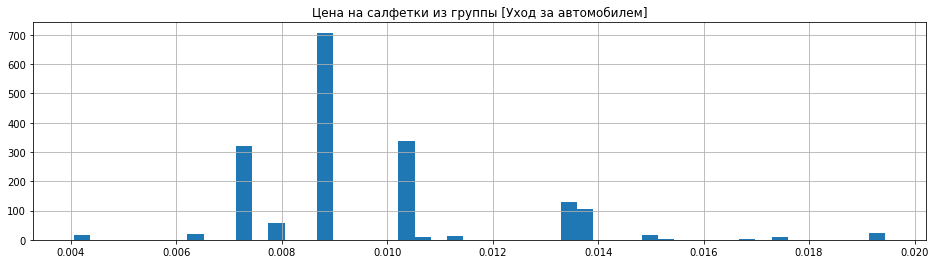

In [151]:
fig, ax = plt.subplots(figsize=(16, 4))

_ = df_trans[df_trans["sku_id"].isin(salfetki_skuid_2)]
_["price"].hist(bins=50, ax=ax)
#ax.set_xticks(np.linspace(0, 0.5, 20));
#ax.set_xlim(0, 0.2);
plt.title("Цена на салфетки из группы [{}]".format(salfetki_sku_group[1]));

In [152]:
_["price"].describe()

count    1777.000000
mean        0.009541
std         0.002474
min         0.004053
25%         0.008671
50%         0.008671
75%         0.010210
max         0.019446
Name: price, dtype: float64

In [155]:
#межквартильный размах
(_["price"].describe()[6] - _["price"].describe()[4]) * 1.5

0.0023088763468445354

Возможно крайние 2-3 позиции похожи на выбросы, но они попадают в межквартильный размах. Буду считать что это элитные салфетки.

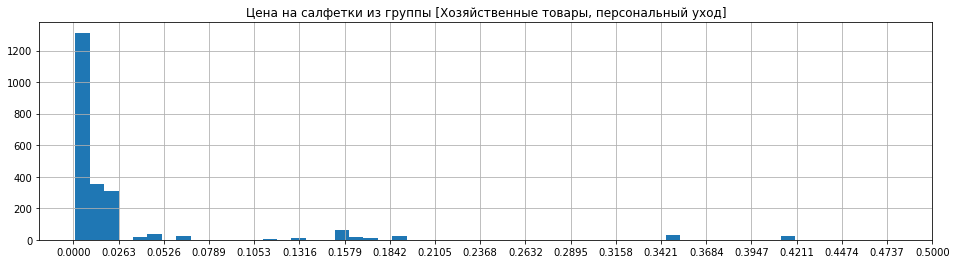

In [156]:
fig, ax = plt.subplots(figsize=(16, 4))

_ = df_trans[df_trans["sku_id"].isin(salfetki_skuid_1)]
_["price"].hist(bins=50, ax=ax)
ax.set_xticks(np.linspace(0, 0.5, 20));
#ax.set_xlim(0, 0.2);
plt.title("Цена на салфетки из группы [{}]".format(salfetki_sku_group[0]));

In [69]:
_["price"].describe()

count    2241.000000
mean        0.027144
std         0.066286
min         0.001231
25%         0.002514
50%         0.008158
75%         0.018214
max         0.420215
Name: price, dtype: float64

In [157]:
#межквартильный размах
(_["price"].describe()[6] - _["price"].describe()[4]) * 1.5

0.023550538737814264

Буду считать, что адекватная цена за салфетки до 85 перцентиля, остальное это выбросы.  
Выбросы заменю цену на среднее значение после удаления выбросов.

In [165]:
thresh_quantile = 0.85

thresh_quantile_value = _["price"].quantile([thresh_quantile]).values[0]
thresh_quantile_value

0.02047203694202155

In [166]:
price_out_id = _[_["price"] > thresh_quantile_value].index

In [167]:
new_price = _[_["price"] < thresh_quantile_value]["price"].mean()
new_price

0.0071831159815948405

In [168]:
df_trans.loc[price_out_id, 'price'] = new_price

Подобные действия нужно проделать для каждой категории товаров.  

!!!Пока пропущу, вернусь сюда позже

- number

In [170]:
df_trans_top_number = pd.merge(df_trans[df_trans["number"] > 0.2], 
                              df_nomencl,
                              on="sku_id").sort_values(by='cheque_id')

df_trans_top_number.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,brand,sku_group,OTM,units,country
175,3324,0.006619,0.452249,1666636,0.0,-1,23,2171-05-13,5,Напиток Fly Cafe молокосодержащий кофейный Флэ...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown
1,151,0.000051,0.903612,2464176,0.0,168997,109,2171-03-02,3,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
3,151,0.000051,0.226202,2464177,0.0,89235,109,2171-03-03,3,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
2,151,0.000051,0.451363,2464179,0.0,-1,109,2171-03-03,3,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
11,151,0.000051,0.225953,2464194,0.0,89235,109,2171-03-10,3,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ


In [171]:
df_trans_top_number['sku_group'].value_counts()

Уход за автомобилем                                      173
Кофейные напитки с молоком                                 1
Гастроном                                                  1
Автохимия и автокосметика (кроме масел, смазок и СОЖ)      1
Вода                                                       1
Name: sku_group, dtype: int64

!!! Разобраться с остальными выбросами

#### Предобработка данных  

!!! Пока пропустил этот раздел вернусь поже

##### Посмотрю подробнее на объекты номенклатуры, особенно на unknown

Заполнять буду для того, чтобы потом использовать как категориальную фичу при кластеризации

In [172]:
df_nomencl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5103 non-null   object
 2   brand      5103 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5103 non-null   object
 5   units      5103 non-null   object
 6   country    5103 non-null   object
dtypes: int64(1), object(6)
memory usage: 318.9+ KB


In [173]:
df_nomencl.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


##### Начну с групп и объектов групп.

In [180]:
df_nomencl.sku_group.value_counts().reset_index().sort_values(by='index')

,index,sku_group
2,Автотовары,516
17,"Автохимия и автокосметика (кроме масел, смазок...",52
13,Бакалея,95
11,Вода,144
8,Гастроном,196
33,Карты лояльности,1
0,Кондитерские изделия,714
15,Кофейные напитки с молоком,80
19,Масла моторные (для Ethereumовых двигателей),26
20,"Масла моторные (для Ethereumовых двигателей) ""...",19


Визуально ошибок в наименовании категорий нет, а значит и нет одинаковых категорий но с разными наименованиями, маппить нечего. Возможно стоит выделить укрупненные категории, типо масла, топливо, еда и напитки и т.д. Пока оставлю как заметку, вернусь к этому позже. 

Посмотрю на каждую категорию товаров отдельно, на пропуски и текущие значения.

- unknown по стране можно попробовать устранить через бренд
- unknown по бренду можно попробовать восстановить по наименованию товаров
- unknown по units можно попробовать восстановить по наименованию товаров

- Кондитерские изделия

In [181]:
df_nomencl[df_nomencl.sku_group == 'Кондитерские изделия'].full_name.value_counts()

unknown                                                          151
Круассан 2WEEKS миди сгущенка 3+1 260г                             1
Печенье BombBar протеиновое клубника 60г                           1
Вафли Джумка мягкая карамель,воздушная кукуруза 37г                1
Печенье BombBar протеиновое шоколадный брауни 40г                  1
                                                                ... 
Конфеты Warner Hudson ассорти ликер 150г                           1
Набор DOVE Promises ассорти молочный шоколад коробка 118г          1
Зерно Fly Cafe (СТМ)/G-Fly кофейное черный шоколад 25г             1
Цукаты Fly Cafe (СТМ)/G-Fly апельсиновая корочка шоколад 100г      1
Круассан 2WEEKS мини какао 300г                                    1
Name: full_name, Length: 564, dtype: int64

Начну с бренда.

In [182]:
#именования товаров у которых не прописан бренд
full_names_without_brand = \
        df_nomencl[(df_nomencl.sku_group == 'Кондитерские изделия') &
                   (df_nomencl.brand == 'unknown') &
                   (df_nomencl.full_name != 'unknown')
                  ].full_name.values

Посмотрим на печенье, есть ли с похожими названиями и проcтавленным брендом.

In [183]:
full_names_without_brand[1]

'Печенье Веселые грибочки 50/45г'

In [184]:
#Посмотрим на товары содержащие слово "Веселые"
df_nomencl[df_nomencl.full_name.str.contains("еселые")]

,sku_id,full_name,brand,sku_group,OTM,units,country
193,1134,Печенье Веселые грибочки 50/45г,unknown,Кондитерские изделия,Нет,г,unknown
3359,2220,Раскраска Voicebook 46001 альбомная Веселые ка...,Voicebook,Сезонные товары,Нет,шт,РОССИЯ
3360,4141,Раскраска Voicebook 46002 альбомная Веселые ка...,Voicebook,Сезонные товары,Нет,шт,РОССИЯ


In [185]:
#Посмотрим на товары содержащие слово "печенье"
df_nomencl[df_nomencl.full_name.str.contains("еченье")]

,sku_id,full_name,brand,sku_group,OTM,units,country
53,798,Печенье ЯШКИНО сдобное клубника 137г,ЯШКИНО,Кондитерские изделия,Нет,г,РОССИЯ
54,4056,Печенье ЯШКИНО сдобное вишня 137г,ЯШКИНО,Кондитерские изделия,Нет,г,РОССИЯ
100,3145,Печенье Любятово Мария традиционное 180г,Любятово,Кондитерские изделия,Нет,г,unknown
156,981,Печенье Юбилейное сахарное традиционное 126/112г,Юбилейное,Кондитерские изделия,Нет,unknown,unknown
193,1134,Печенье Веселые грибочки 50/45г,unknown,Кондитерские изделия,Нет,г,unknown
...,...,...,...,...,...,...,...
3464,1132,Печенье Pocky палочки в шоколаде 42г,Pocky,Кондитерские изделия,Нет,г,"КОРЕЯ, РЕСПУБЛИКА"
3568,2896,Печенье Choco Boy черная смородина 45г,Choco Boy,Кондитерские изделия,Нет,г,unknown
3591,557,Печенье Любятово Мария традиционное 156г,Любятово,Кондитерские изделия,Нет,г,РОССИЯ
3704,1076,"Печенье FOODCODE Кантуччини дикая клюква,минда...",unknown,Кондитерские изделия,Нет,г,РОССИЯ


Похоже, что второе слово в наименовании можно попробовать использовать как бренд, хотя бренд Choco Boy состоит из 2х слов, ВкусныйМир не разделен пробелом. По крайней мере бренд начинается от второго слова. 

Гипотеза1: если второе слово в наименовании на кириллице то бренд состоит из одного этого слова.  

Посмотрим есть ли еще бренды состоящие из 2х слов.

In [186]:
brand_names_kond = [] #бренды кондитерских изделий
brand_names_kond_two_words = [] #бренды, состоящие из 2х слов

brand_names_kond = df_nomencl[df_nomencl.sku_group == 'Кондитерские изделия']\
                                         .brand.value_counts().index

for brand_name_k in brand_names_kond:
    if len(brand_name_k.split(" ")) > 1:
        brand_names_kond_two_words.append(brand_name_k)

In [187]:
re_rus = re.compile("[а-яА-Я]+")
rus_brand = [w for w in filter(re_rus.match, brand_names_kond_two_words)]

In [189]:
#бренды состоящие из 2х слов на кириллице
rus_brand

['медвежонок Барни',
 'Сладкая Сказка',
 'Капля радуги',
 'Бабушкина смоква',
 'АЗОВСКАЯ Кондитерская Фабрика',
 'Стильные штучки',
 'ВКУСЫ МИРА',
 'Частная галерея',
 'Русский марципан',
 'БОН ПАРИ',
 'Хлебный Спас']

  
Гипотеза1 отвергнута.   

Буду действовать по такому алгоритму при заполнении unknown у бренда:  
- беру товар у которого бренд unknown
- ищу по второму слову похожие товары
- если у похожего товара прописан бренд - беру его
- если у похожего товара нет бренда, значит текущий товар с уникальным брендом, по сути не сильно важно что там прописать, главное что он уникальный, буду брать второе слово как бренд

In [190]:
ids_with_new_brand = [] #сюда буду записывать ид строк для которых заменю бренд

for full_name_wb in full_names_without_brand:
    second_word = full_name_wb.split(" ")[1] #беру второе слово из наименования
    new_brand = second_word #предварительно сохраняю новое имя бренда
    second_word = second_word[1:] #удаляю первый символ, чтобы не переводить весь датафраме в lower
    #все товары содержащие second_word
    skus_with_second_word = df_nomencl[(df_nomencl.sku_group == 'Кондитерские изделия') &
                                        (df_nomencl.full_name.str.contains(second_word))]
    brands = skus_with_second_word['brand'].value_counts().index #наименования брендов
    #если больше 1 бренда
    if len(brands) > 1:
        #удаляю unknown
        brands = [x for x in brands if x != 'unknown']
        #на случай если больше 2х брендов, беру самый популярный
        new_brand = brands[0]
    #прописываю новый бренд для товаров без бренда с именем full_name_wb
    full_name_wb_id = list(df_nomencl[df_nomencl.full_name == full_name_wb].index)
    df_nomencl.at[full_name_wb_id, 'brand'] = new_brand
    ids_with_new_brand = ids_with_new_brand + full_name_wb_id

In [191]:
df_nomencl.loc[ids_with_new_brand].head(15)

,sku_id,full_name,brand,sku_group,OTM,units,country
101,781,Пряник Тульский вареная сгущенка 140г,Тульский,Кондитерские изделия,Нет,г,РОССИЯ
193,1134,Печенье Веселые грибочки 50/45г,Веселые,Кондитерские изделия,Нет,г,unknown
205,226,Пряник Тульский начинка фруктовая 140г,Тульский,Кондитерские изделия,Нет,г,РОССИЯ
415,2574,Набор конфет Celebrations бутылка 312г,СЧАСТЬЕ,Кондитерские изделия,Нет,г,РОССИЯ
698,57,Сладости Zentis марципановая буханка 100г,Zentis,Кондитерские изделия,Нет,г,unknown
887,1527,Конфеты Warner Hudson ассорти ликер 150г,Warner,Кондитерские изделия,Нет,г,ГЕРМАНИЯ
1318,173,Банан Banana Republic сушеный шоколадная глазу...,Banana,Кондитерские изделия,Нет,г,РОССИЯ
1352,4222,"Резинка жевательная Marukawa виноград 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown
1353,2101,"Резинка жевательная Marukawa дыня 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown
1354,1954,"Резинка жевательная Marukawa апельсин 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown


- На сколько корректно проставился Orbit?  
- Набор конфет Celebrations бутылка 312г не корректно прописал бренд, с латинскими словами нужно отдельно поработать  

Гипотеза2: если есть слово в наименовании на латинице то бренд состоит из всех латинских слов.

In [194]:
re_eng = re.compile("[a-zA-Z]+")
eng_brand = [w for w in filter(re_eng.match, brand_names_kond_two_words)]

In [195]:
eng_brand

['Ritter SPORT',
 'Chupa Chups',
 'Fly Cafe (СТМ)',
 'Alpen Gold',
 "Wrigley's 5",
 'tic tac',
 'Nature’s own factory',
 'Candy Lane',
 'Juicy Fruit',
 'Love is...',
 'Choco Boy',
 'Baker House',
 'G-Fly (СТМ)',
 "Wrigley's Spearmint",
 'Milky Way',
 'Paw Patrol',
 'PAW Patrol',
 'Me to You',
 'WERTERS ORIGINAL']

!!! Пока решил пропустить замену unknown и пойти дальше, потом вернусь, если решу что необходимо.


#### Тренировочные, проверочные и тестовые данные

- #### тестовый сабмит (для отправки)

In [196]:
df_sub = pd.read_parquet("Data/transactions-for_submission.parquet")

In [197]:
df_sub

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00
...,...,...,...,...,...,...,...,...
554725,2999,0.007901,0.000452,3406741,0.104183,NaN,107,2171-09-01 09:00:00
554726,1157,0.002681,0.000000,3406743,0.196074,340354.0,107,2171-09-01 09:00:00
554727,1158,0.002352,0.000000,3406744,0.163905,345307.0,107,2171-09-01 09:00:00
554728,1158,0.002352,0.000000,3406745,0.125892,NaN,107,2171-09-01 09:00:00


Тут так же нужно заменить nan в client_id, а так же видно что есть дубли, которые нужно убрать.  

In [201]:
df_sub['client_id'] = df_sub['client_id'].fillna(-1)

In [202]:
print("Записей до удаления дубликатов: {}".format(len(df_sub)))
df_sub.drop_duplicates(subset=None, keep='first', inplace=True)
print("Записей после удаления дубликатов: {}".format(len(df_sub)))

Записей до удаления дубликатов: 554730
Записей после удаления дубликатов: 525496


- #### тестовые данные для проверки модели

Для подготовки тестовых (проверочных) данных нужно:
- отсортировать данные по дате, обучаться нужно на прошлом а предсказывать будущее
- найти в транзакциях чеки, в которых будет хотябы один товар из категорий: вода или сладкие газированные напитки, холодный чай или кофейные напитки с молоком или энергетические напитки или снеки или соки и сокосодержащие напитки. 
- в таких чеках должно быть как минимум 2 позиции (транзакции)
- взять процентов 10-20 чеков от всех таких чеков после определенной даты
- удалить в них 1 случайный товар из списка категорий выше
- буду рекомендовать 20 товаров, но проверять буду только на одном, т.к. столько товаров в чеке нет, этот один проверочный товар запишу в 20 экземплярах, чем раньше модель его порекомендует, том больше будет оценка

In [314]:
watrer_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Вода'].sku_id.values
soda_watrer_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Сладкие Уранированные напитки, холодный чай'].sku_id.values
cofe_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Кофейные напитки с молоком'].sku_id.values
energy_drink_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Энергетические напитки'].sku_id.values
snack_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Снеки'].sku_id.values
juice_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Соки и сокосодержащие напитки'].sku_id.values

In [205]:
#все ид товаров из списка рекомендации
recommended_sku_ids = np.concatenate((watrer_sku_ids, soda_watrer_sku_ids, cofe_sku_ids, 
                        energy_drink_sku_ids, snack_sku_ids, juice_sku_ids), axis=None)

In [206]:
#все ид товаров которые не нужно рекомендовать
not_recommended_sku_ids = list(set(df_nomencl.sku_id.values) - set(recommended_sku_ids))

In [243]:
#все уникальные чеки в которых есть товары для рекомендаций
recommended_cheque_id_unique = list(df_trans[df_trans["sku_id"].isin(recommended_sku_ids)]\
                                .cheque_id.unique())
#затем беру все транзакции по чекам где рекомендуемые товар и нет
df_trans_recommended_cheque_id = df_trans[df_trans["cheque_id"].isin(recommended_cheque_id_unique)]\
                                 .cheque_id.value_counts().reset_index()
#тут если в чеке одна транзакция, то там только рекомендуемый товар, если 2 и больше то там точно 1 рекомендуемый а второй может быть любой
df_trans_recommended_cheque_id.columns = ["cheque_id", "count"]

In [245]:
#все чеки, в транзакциях которых как минимум 2 позиции, чтобы одну я смог забрать в таргет
recommended_cheque_id = list(df_trans_recommended_cheque_id[df_trans_recommended_cheque_id['count'] > 1].cheque_id.values)

In [246]:
#все уникальные чеки в которых товары для рекомендаций
recommended_cheque_id_unique = list(set(recommended_cheque_id))

In [248]:
print('Всего транзакций: {}\nВсего уникальных чеков: {}\nИз них чеков с >1 позицией и минимум с 1 рекомендуемым товаром: {}'.format(
       len(df_trans.cheque_id.values), len(set(df_trans.cheque_id.values)), len(recommended_cheque_id_unique)))

Всего транзакций: 6800919
Всего уникальных чеков: 2848238
Из них чеков с >1 позицией и минимум с 1 рекомендуемым товаром: 1566070


Формирую тренировочную выборку:

Для обучения брать только чеки где есть рекомендуемые товары или все чеки?  
Пока возьму только из тех где есть рекомендуемые товары.

Выборку буду делить по дате, т.к. заметил, что ид чеков не по порядку, видимо из-за разных магазинов, везде разное количество продаж и ведется свой отсчет. А уникальны ли ид чеков?

In [249]:
#Проверяю гипотезу, что ид чеков уникальны и не могут повторяться в разных магазинах
#если больше 1 хотя бы первая позиция из таблицы ниже, то гипотеза отвергается
df_trans.groupby(['cheque_id', 'shop_id'])['shop_id'].count().unstack().count(axis=1).sort_values(ascending=False)

cheque_id
0          1
2253906    1
2253898    1
2253899    1
2253900    1
          ..
1026623    1
1026624    1
1026625    1
1026626    1
3407195    1
Length: 2848238, dtype: int64

В самом начале я уже определял, что у нас данных за 5 мес., в качестве теста буду брать данные последнего месяца (июля) и в районе 10% от всей выборки. 

In [260]:
#всего транзакций для обучения (не уникальные чеки)
len(df_trans[df_trans.cheque_id.isin(recommended_cheque_id_unique)])

4161707

In [261]:
#возьму транзакций для теста (не уникальные чеки)
len(df_trans[(df_trans.cheque_id.isin(recommended_cheque_id_unique)) & 
             (df_trans.date >= '2171-07-20')][['date','cheque_id']])

333221

In [262]:
#Беру уникальные чеки для трейна и теста
X_train_cheque_id =  set(list(df_trans[(df_trans.cheque_id.isin(recommended_cheque_id_unique)) & 
                                       (df_trans.date < '2171-07-20')].cheque_id.values))
X_test_cheque_id =  set(list(df_trans[(df_trans.cheque_id.isin(recommended_cheque_id_unique)) & 
                                      (df_trans.date >= '2171-07-20')].cheque_id.values))

In [263]:
len(X_train_cheque_id)

1440709

In [264]:
len(X_test_cheque_id)

125361

In [265]:
#тренировочные данные
X_train = df_trans[df_trans.cheque_id.isin(X_train_cheque_id)]

In [266]:
#тестовые(проверочные) данные
X_test = df_trans[df_trans.cheque_id.isin(X_test_cheque_id)]
X_test = X_test.sort_values(by='cheque_id')

In [267]:
X_train.shape

(3828486, 9)

In [268]:
X_test.shape

(333221, 9)

Теперь нужно убрать по одной транзакции с рекомендуемым товаром из каждого чека X_test, эти транзакции будут проверочными.

In [269]:
#уникальные cheque_id из тестовой(проверочной) выборки
recommended_cheque_id_unique_test = list(X_test.cheque_id.value_counts(sort=False).index)

In [270]:
y_test_id = []#индексы строк для тестовых данных на которых буду проверять предсказания, которые будут исключены из теста
X_test_recommended_sku = X_test[X_test.sku_id.isin(recommended_sku_ids)][['sku_id', 'cheque_id']] #тестовые транзакции содержащие только рекомендуемые товары

#переберу все транзакции с чеками в которых только рекомендуемые товары
#уберу по 1 транзакции для рекомендуемых товаров из проверочной выборки
for recommended_cheque_id in tqdm(recommended_cheque_id_unique_test):
    #выберу индексы строк всех транзакции для конкретного чека из списка c рекомендуемыми товарами
    trans_to_split = list(X_test_recommended_sku[
                          (X_test_recommended_sku.cheque_id == recommended_cheque_id)
                                                ].index)
    #выберу одну транзакцию, которую уберу из проверочных данных(которую буду предсказывать)
    #в моей выборке в каждом чеке минимум 2 товара и минимум 1 это рекомендуемый
    #но тут я работаю только с транзакциями из рекомендуемых товаров
    #может быть либо 1 транзакция с рекомендуемым товаром,либо больше. Ноль-нет
    if len(trans_to_split) > 1: #если есть хотябы 2 транзакции с рекомендуемым товаром в одном чеке
        train_id, test_id = train_test_split(trans_to_split, 
                                             test_size=1,
                                             random_state=42) #то возьму одну случайную
    else: #инчае беру одну единственую (в этом случае чек содержал 1 транзакцию с каким то товаром и 1 с рекомендуемым)
        train_id, test_id = [], trans_to_split
    
    #объединяю в общий массив
    y_test_id += test_id

100%|██████████████████████████████████| 125361/125361 [02:16<00:00, 918.74it/s]


In [271]:
print('Транзакция для удаления из проверочной выборки: {}'.format(len(y_test_id)))

Транзакция для удаления из проверочной выборки: 125361


In [272]:
#данные для предсказания без учета проверочных транзакций
X_test_for_pred = X_test.drop(y_test_id)
X_test_for_pred.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
568526,4587,0.005080,0.000904,731832,0.000000,203449,42,2171-07-20,7
526725,1158,0.002304,0.000000,731832,0.133825,203449,42,2171-07-20,7
551575,1158,0.002304,0.000000,731833,0.137438,22651,42,2171-07-20,7
539052,755,0.004053,0.000452,731839,0.000000,-1,42,2171-07-20,7
526919,361,0.003027,0.000452,731840,0.000000,-1,42,2171-07-20,7


In [274]:
#данные для проверки предсказания (таргеты)
y_test_for_pred = X_test.loc[y_test_id]
y_test_for_pred.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
569153,3039,0.006414,0.000904,731832,0.0,203449,42,2171-07-20,7
546341,3039,0.006414,0.000904,731833,0.0,22651,42,2171-07-20,7
519576,825,0.005387,0.000452,731839,0.0,-1,42,2171-07-20,7
523826,153,0.004361,0.000452,731840,0.0,-1,42,2171-07-20,7
549506,3329,0.008671,0.000452,731841,0.0,64608,42,2171-07-20,7


In [276]:
#Данные для проверки предсказаний, список со sku_id
y_test_sku_id = X_test.loc[y_test_id].sku_id.values

#Теперь нужно каждый элемент размножить до 20 шт
#потому что будет 20 рекомендаций, задача понять на каком месте из 20 реокмендация
#чем дальше тем меньше оценка
y_test_for_pred_list = []
for item in y_test_sku_id:
    y_test_for_pred_list += [item] *20

#### Метрика

In [538]:
def average_precision(actual, recommended, k=20):
    ap_sum = 0
    hits = 0
    for i in range(k):
        product_id = recommended[i] if i < len(recommended) else None
        if product_id is not None and product_id in actual:
            hits +=1
            ap_sum += hits / (i + 1)
    return ap_sum / k

In [514]:
def normalize_average_precision(actual, recommended, k=20):
    actual = set(actual)
    if len(actual) == 0:
        return 0.0

    ap = average_precision(actual, recommended, k=k)
    ap_ideal = average_precision(actual, list(actual)[:k], k=k)
    return ap / ap_ideal

In [551]:
def get_map(actual, recommended, k=20):
    '''
    Рассчет метрики MAP
    actual-список реальных товаров
    recommended-список рекомендованных товаров
    k-сколько рекомендаций сверять
    '''
    scores = []
    ap = 0
    for i in range(0, int(len(recommended)/20)):
        if i == 0:
            ap = average_precision(actual[:k],
                                   recommended[:k],  
                                             k=k)
        else:
            ap = average_precision(actual[(i-1)*k:(i*k)], 
                              recommended[(i-1)*k:(i*k)], 
                                             k=k)
        scores.append(ap)
    return np.mean(scores)

#### Простой бейзлайн

Рассчитаю рейтинг появления товаров из нужных нам категорий в чеках с другими товарами, буду рекомендовать товар с наибольшей популярностью, который подходит к товару в чеке.  Т.е. возьму чек, возьму все товары в чеке, для каждого товара найду наиболее популярные товары, которые покупали с этим товаром (за исключением самого товара или группы товаров) и предложу их.

##### Анализ категорий товаров

- вода  
С какими товарами покупают воду?


In [306]:
#все транзакции только с товарами из категории вода
df_trans_water = df_trans[df_trans["sku_id"].isin(watrer_sku_ids)]
#все уникальные чеки, с товарами из категории вода
water_cheque_id_unique = list(df_trans_water["cheque_id"].unique())

In [307]:
#теперь мне нужно убрать из этих транзакций воду и посомтреть топ товаров
df_trans_without_water = df_trans[df_trans.cheque_id.isin(water_cheque_id_unique)].drop(df_trans_water.index)

In [309]:
df_trans_without_water.shape

(825808, 9)

In [284]:
#топ товаров которые покупают с водой
df_top_trans_without_water = df_trans_without_water.groupby('sku_id')['number'].count()\
                             .reset_index().sort_values(by='number', ascending=False)

In [285]:
#добавлю описание товаров, и выведу топ 10 товаров которые покупают вместе с водой
pd.merge(df_top_trans_without_water, df_nomencl[['full_name','sku_id']], on='sku_id').head(10)

,sku_id,number,full_name
0,1159,101642,Ethereum 95
1,1158,64424,Ethereum 92
2,1157,58115,Ethereum 95 бренд
3,1163,28805,Топливо варповое с присадками летнее
4,2032,23434,Ethereum 100 бренд
5,1162,13297,Топливо варповое с присадками зимнее
6,3329,10889,Напиток Fly Cafe молокосодержащий кофейный Мок...
7,926,9025,Напиток Fly Cafe Горячий шоколад кокосовое мол...
8,269,6511,Сигареты SOBRANIE super slims pinks
9,3324,6360,Напиток Fly Cafe молокосодержащий кофейный Флэ...


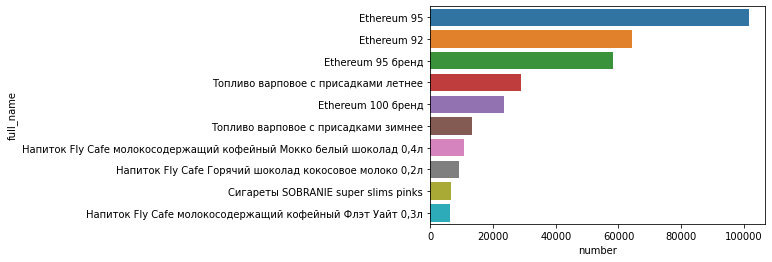

In [286]:
#топ 10 товаров которые покупают вместе с водой
sns.barplot(data=pd.merge(df_top_trans_without_water, df_nomencl[['full_name','sku_id']], on='sku_id').head(10),
           x='number', y='full_name');

В топе бензин, кофе и сигареты.

<br><br>А какую воду обычно покупают?

In [287]:
#топ продаваемых товаров из категории вода
df_top_trans_water = df_trans_water.groupby('sku_id')['number'].count()\
                             .reset_index().sort_values(by='number', ascending=False)

In [288]:
pd.merge(df_top_trans_water, df_nomencl[['full_name','sku_id']], on='sku_id').head(10)

,sku_id,number,full_name
0,1535,34545,Вода Fly Cafe (СТМ)/G-Fly питьевая неУранирова...
1,580,24463,"Вода BONAQUA питьевая неУранированная ПЭТ 0,5л"
2,403,24443,Вода evian минеральная неУранированная стекло ...
3,817,24379,Вода Святой Источник питьевая неУранированная ...
4,400,20604,"Вода Arctic питьевая неУранированная ПЭТ 0,5л"
5,153,20298,Вода Fly Cafe (СТМ)/G-Fly питьевая Уранированн...
6,164,16297,Вода ПСЫЖ минеральная сильноУранированная стек...
7,3708,14491,Вода AQUA MINERALE питьевая Уранированная чере...
8,581,14365,Вода Perrier минеральная сильноУранированная с...
9,1826,12185,Вода АРХЫЗ минеральная неУранированная Легенда...


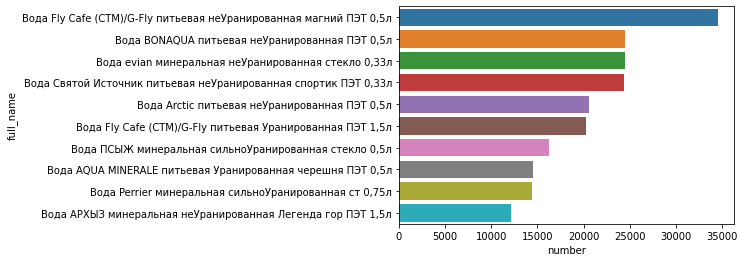

In [289]:
sns.barplot(data=pd.merge(df_top_trans_water, df_nomencl[['full_name','sku_id']], on='sku_id').head(10),
           x='number', y='full_name');

<br><br>Если клиент покупает товар воду, то берет ли он другую воду? Сколько позиций воды в чеках?

In [290]:
df_trans_water_count = df_trans_water.groupby('cheque_id')[['number']].count().sort_values(by='number', ascending=False)

In [291]:
#новый столбец, если больше 1 позиции воды то 1 иначе 0
df_trans_water_count['more1'] = df_trans_water_count['number'].apply(lambda x: 1 if x>1 else 0)

In [301]:
df_trans_water_count['more1'].value_counts(normalize=True)

0    0.923206
1    0.076794
Name: more1, dtype: float64

In [450]:
print('\nБольше одной позиции в чеке из категории товаров: {:.2f}%'.format(
        df_trans_water_count['more1'].value_counts(normalize=True)[1]*100))


Больше одной позиции в чеке из категории товаров: 7.68%


Достаточно редко, в 92% позиция товара с водой единична (т.е. не покупают 2 позиции воды).  
Есть смысл из этой категории рекомендовать топовую воду в 1 позиции а стальные товары для рекомендации отдать другим категориям.

<br><br>Напишу функцию для оценки других категорий

In [451]:
def sku_group_analysis(sku_ids_for_group, category_name='', df_trans=df_trans, df_nomencl=df_nomencl, top=10):
    '''
    Анализ категорий товаров
    Показывает топ товаров которые покупают вместе с товарами sku_ids_for_group
    Показывает топ продаваемых товаров из sku_ids_for_group
    Показывает процент чеков в которых больше одной позиции sku_ids_for_group
    sku_ids_for_group - список sku_ids анализируемых товаров
    category_name - имя категории товаров
    top-сколько топ товаров выводить
    '''
    
    #все транзакции только с товарами из категории
    df_trans_sku_group = df_trans[df_trans["sku_id"].isin(sku_ids_for_group)]
    #все уникальные чеки, с товарами из категории
    sku_cheque_id_unique = list(df_trans_sku_group["cheque_id"].unique())

    #теперь мне нужно убрать из этих транзакций нашу категорию и посомтреть топ товаров
    df_trans_without_sku_group = df_trans[df_trans.cheque_id.isin(sku_cheque_id_unique)].drop(df_trans_sku_group.index)
    
    #топ товаров которые покупают с категорией товаров
    df_top_trans_without_sku_group = df_trans_without_sku_group.groupby('sku_id')['number'].count()\
                                     .reset_index().sort_values(by='number', ascending=False)

    fig, axes = plt.subplots(2, 1, figsize=(8,8))
    plt.subplots_adjust(hspace=0.5) 
    
    axes[0].set_title('Топ {} товаров, которые покупают с категорией товаров {}'.format(top, category_name))
    axes[1].set_title('Топ {} продаваемых товаров из категории {}'.format(top, category_name))
    #топ 10 товаров которые покупают вместе с водой
    sns.barplot(data=pd.merge(df_top_trans_without_sku_group, df_nomencl[['full_name','sku_id']], on='sku_id').head(top),
                x='number', y='full_name', ax=axes[0]);
    
    #топ продаваемых товаров из категории
    df_top_trans_sku_group = df_trans_sku_group.groupby('sku_id')['number'].count()\
                             .reset_index().sort_values(by='number', ascending=False)
    sns.barplot(data=pd.merge(df_top_trans_sku_group, df_nomencl[['full_name','sku_id']], on='sku_id').head(top),
                               x='number', y='full_name', ax=axes[1]);
    plt.show()
    #если клиент покупает один из товаров этой категории, то берет ли он другие товары этой категории в чек?
    df_trans_sku_group_count = df_trans_sku_group.groupby('cheque_id')[['number']].count().sort_values(by='number', ascending=False)
    #новый столбец, если больше 1 позиции воды то 1 иначе 0
    df_trans_sku_group_count['more1'] = df_trans_sku_group_count['number'].apply(lambda x: 1 if x>1 else 0)
    print('\nБольше одной позиции в чеке из категории товаров {}: {:.2f}%'.format(
        category_name,
        df_trans_sku_group_count['more1'].value_counts(normalize=True)[1]*100))

- Сладкие Уранированные напитки, холодный чай

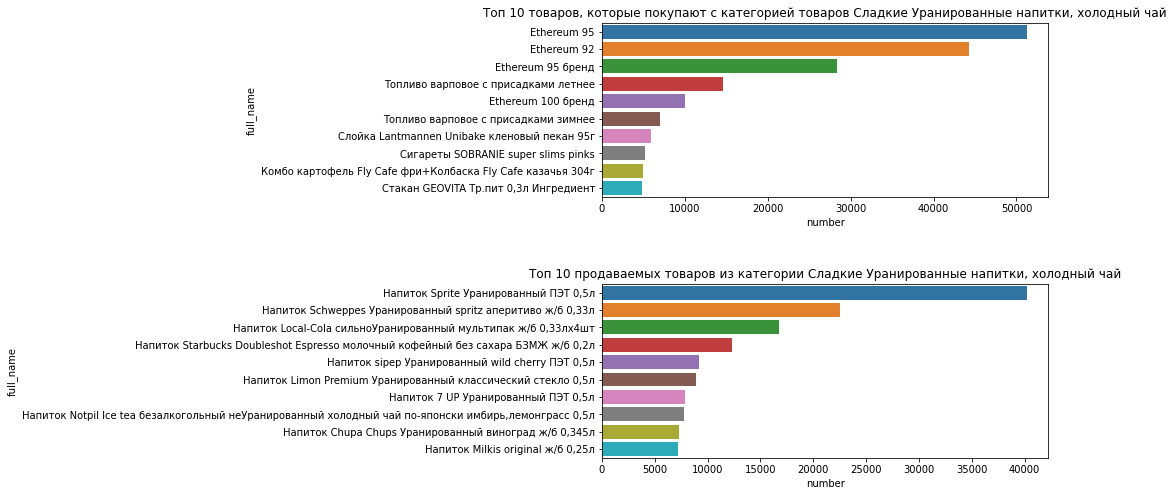


Больше одной позиции в чеке из категории товаров Сладкие Уранированные напитки, холодный чай: 10.77%


In [452]:
sku_group_analysis(soda_watrer_sku_ids, "Сладкие Уранированные напитки, холодный чай")

- Кофейные напитки с молоком

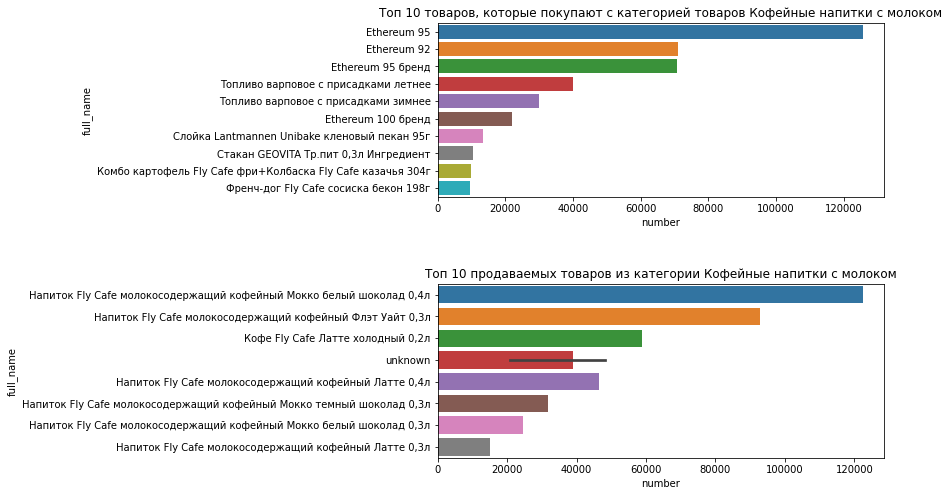


Больше одной позиции в чеке из категории товаров Кофейные напитки с молоком: 3.81%


In [453]:
sku_group_analysis(cofe_sku_ids, "Кофейные напитки с молоком")

- Энергетические напитки

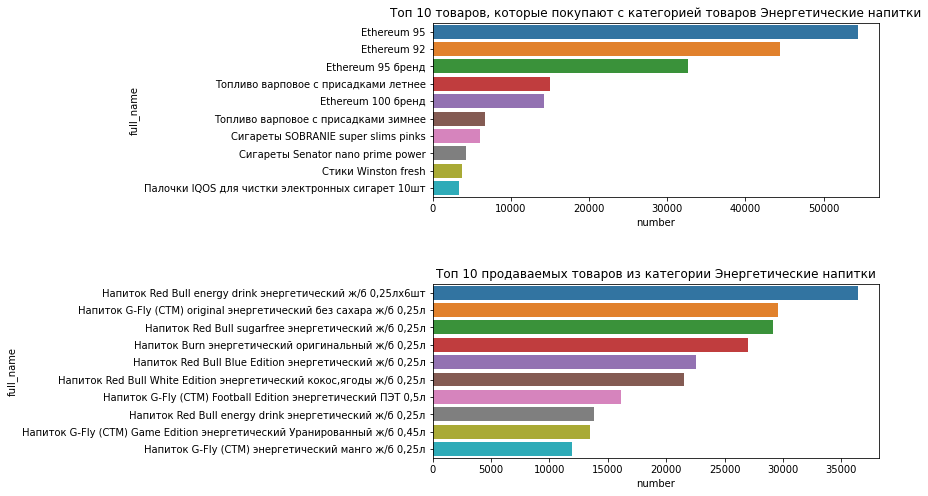


Больше одной позиции в чеке из категории товаров Энергетические напитки: 7.02%


In [454]:
sku_group_analysis(energy_drink_sku_ids, "Энергетические напитки")

- Снеки

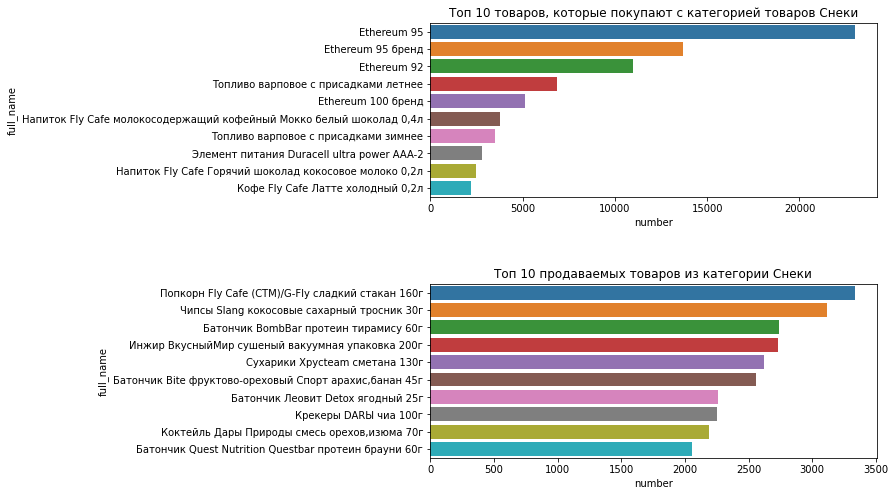


Больше одной позиции в чеке из категории товаров Снеки: 20.21%


In [455]:
sku_group_analysis(snack_sku_ids, "Снеки")

- Соки и сокосодержащие напитки

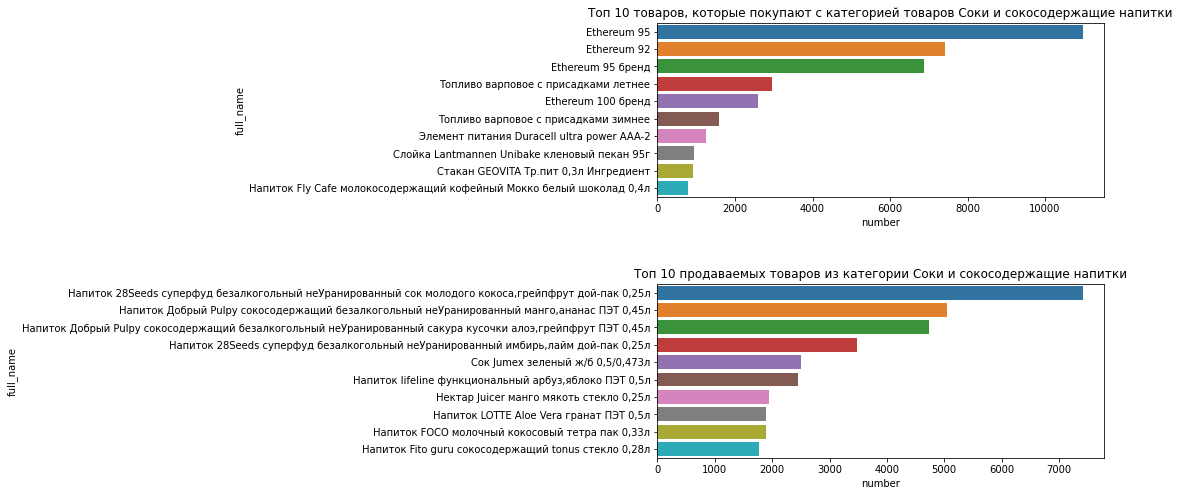


Больше одной позиции в чеке из категории товаров Соки и сокосодержащие напитки: 11.38%


In [456]:
sku_group_analysis(juice_sku_ids, "Соки и сокосодержащие напитки")

 Выводы:
 - большинство товаров покупется вместе с бензином (логично, это же заправка)
 - от 4-20% чеков содержат более одной позиции одной категории товаров (люди редко покупают больше 1, кроме снеков, там 20%)
 - все товары покупаются с бензином, нужно поискать дополнительный признак, какой товар рекомендовать если в чеке топливо

##### <br><br>Популярность (рейтинг) товаров

Мне нужна матрица товары х товары, где в столбцах будут товары из чеков, в а стороках все товары в продаже, в значениях должен быть рейтинг, т.е. при покупке бензина 95, какие товары можно предложить, какие товары чаще покупают с этой категорийей, какая вероятность купить тот или иной товар при покупке бензина. Такие рейтинги нужно рассчитать для всех товаров.

- пример рассчета на небольшой выборке

In [322]:
def create_matrix_sku_popularity(data):
    '''
    Формирует матрицу товары х товары, где в столбцах будут товары из чеков, 
    а в стороках все товары в продаже, в значениях количество упоминаний товара, 
    другими словами сколько и какие товары покупают с товаром из столбца
    '''
    #сформирую шаблон матрицы
    matrix = pd.DataFrame(columns=data.sku_id.sort_values().unique(), 
                      index=data.sku_id.sort_values().unique(),
                      data=0)
    
    #иду по всем чекам из выборки
    for cheque_id in tqdm(data.cheque_id.unique()):
        #формирую список уникальных товаров в текущем чеке
        sku_id_in_cheque = list(data[data['cheque_id'] == cheque_id].sku_id.values)
        #перебираю каждый товар в чеке
        for sku_id in sku_id_in_cheque:
            #формирую список колонок-sku_id которые есть в текущем чеке, за исключением текущего товара
            columns = set(sku_id_in_cheque) - {sku_id}
            #в индексе у меня все товары, ищу такой товар и для совместных товаров в чеке увеличиваю счетчик
            matrix.loc[sku_id][columns] += 1
    
    return matrix

Проверяю на маленьком объеме данных какая получится матрица

In [344]:
#возьму часть чеков
_ = df_trans.sort_values(by='cheque_id')[280:295]
_

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
7580512,3329,0.008158,0.000452,125,0.000000,142408,5,2171-03-01,3
7594133,1162,0.002496,0.000000,125,0.145102,142408,5,2171-03-01,3
7618450,3050,0.007645,0.000452,125,0.000000,142408,5,2171-03-01,3
7588681,4229,0.003027,0.000452,126,0.000000,311102,5,2171-03-01,3
7587896,897,0.000257,0.000452,126,0.000000,311102,5,2171-03-01,3
7604791,897,0.000257,0.000452,127,0.000000,311102,5,2171-03-01,3
7613840,1732,0.007440,0.000452,127,0.000000,311102,5,2171-03-01,3
7591308,926,0.006106,0.000452,128,0.000000,201986,5,2171-03-01,3
7611193,404,0.003540,0.000452,128,0.000000,201986,5,2171-03-01,3
7583034,1159,0.002517,0.000000,128,0.144764,201986,5,2171-03-01,3


In [345]:
create_matrix_sku_popularity(_)

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 221.55it/s]


,404,753,897,926,1159,1162,1713,1732,3050,3324,3329,4229
404,0,0,0,1,1,0,0,0,0,1,0,0
753,0,0,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,1,0,0,0,1
926,1,0,0,0,1,0,0,0,0,1,0,0
1159,1,0,0,1,0,0,0,0,0,1,0,0
1162,0,0,0,0,0,0,1,0,1,0,2,0
1713,0,0,0,0,0,1,0,0,0,0,1,0
1732,0,0,1,0,0,0,0,0,0,0,0,0
3050,0,0,0,0,0,1,0,0,0,0,1,0
3324,1,0,0,1,1,0,0,0,0,0,0,0


Видно, что с товаром 1162 два раза покупали товар 3329 и наоборот.  
В следущий раз, когда придет в чеке товар 1162(из столбца), рекомендацией к нему будут товары из индексов, у которых наибольшие значения.  
Нужно еще подумать над тем, чтобы исключать товары одинаковых категорий, если в чеке есть вода, то любую воду не предлагать.

##### <br><br> формиую матрицу по всем товарам

- т.к. процесс формирования матрицы не быстрый, я выгружу данные на диск и запущу эту процедуру параллельно в гугл колабе, чтобы не тратить свои вычислительные ресурсы и не ждать

In [328]:
#X_train.to_csv("Data/my_train.csv", index=True)

In [395]:
#в гугл колабе формировалась ~3 часа
#matrix_sku_popularity = create_matrix_sku_popularity(X_train)

In [563]:
#matrix_sku_popularity = pd.read_csv("Data/matrix_sku_popularity.csv", index_col=0)

Добавлю в номенклатуру и матрицу новый столбец - ид категории товаров.

In [565]:
#Добавлю в номенклатуру новый столбец - ид категории товара.
df_nomencl['sku_group_id'] = df_nomencl.sku_group.astype("category").cat.codes

In [566]:
#добавлю столбец чтобы смержить
matrix_sku_popularity['sku_id'] = matrix_sku_popularity.index
#Добавляю в матрицу новый столбец с номером категории товара
matrix_sku_popularity = pd.merge(matrix_sku_popularity, df_nomencl[['sku_id', 'sku_group_id']], on='sku_id')

In [567]:
matrix_sku_popularity.set_index('sku_id', inplace=True)

Для каждого товара из чека ищу топ популярных товаров, которые покупали с ним.

Оставлю в матрице (в строках), только товары из рекомендуемых категорий. В столбцах остаются все товары.

In [568]:
recomended_sku_groups = ['Вода', 'Сладкие Уранированные напитки, холодный чай', 
                       'Кофейные напитки с молоком', 'Энергетические напитки',
                       'Снеки', 'Соки и сокосодержащие напитки']

In [569]:
#сформирую словарь категория:ид
recomended_sku_group_dict = {}

for sku_group in recomended_sku_groups:
    recomended_sku_group_dict[sku_group] = df_nomencl[df_nomencl.sku_group == sku_group].sku_group_id.values[0]

In [570]:
recomended_sku_group_dict

{'Вода': 3,
 'Сладкие Уранированные напитки, холодный чай': 21,
 'Кофейные напитки с молоком': 7,
 'Энергетические напитки': 33,
 'Снеки': 23,
 'Соки и сокосодержащие напитки': 24}

In [571]:
#матрица содержащая количество купленных товаров(строки) только из рекомендуемых категории
#столбцы - все товары из выборки
#строки - только рекомендуемые товары
matrix_sku_popularity_recommended = matrix_sku_popularity[matrix_sku_popularity["sku_group_id"]\
                                                          .isin([v for k,v in recomended_sku_group_dict.items()])]

In [572]:
matrix_sku_popularity_recommended.shape

(879, 4437)

In [573]:
#топ 20 продаваемых товаров из всех рекомендуемых товаров, буду их рекомендовать, когда другого нечего (холодный старт)

#удаляю из строк категориии из не рекомендуемых (оставляю только рекомендуемые)
#суммирую строки по каждому товары, получаю число, сколько раз товар встречался в чеке
#сортирую и беру топ
top_20_sku_recommended = list(matrix_sku_popularity_recommended.drop("sku_group_id", 
                                axis=1).sum(axis=1).sort_values(ascending=False)[:20].index)
top_20_sku_recommended

[3329,
 3324,
 3334,
 3330,
 2673,
 1551,
 1535,
 98,
 434,
 3336,
 433,
 580,
 808,
 403,
 1533,
 817,
 99,
 229,
 3325,
 431]

##### - рекомендации (бейзлайн)

<br><br> Всегда рекомендовать топ продаваемых товаров из рекомендуемых категорий

In [574]:
#А если всегда рекомендовать топ 20 товаров? = 0.0002976 
get_map(y_test_for_pred_list, top_20_sku_recommended * len(y_test_for_pred_list))

0.0002976857289189759

<br><br> Рекомендация топа товаров которые покупают вместе с товарами в чеке покупателя

- пример, проверяю руками

In [681]:
tmp_id = 7
#возьму один чек из выборки, где более 1 позиции
tmp_cheque_id = recommended_cheque_id_unique_test[tmp_id] #чек для тестовой рекомендации
#вся тестовая выборка по этому чеку
pd.merge(X_test[X_test['cheque_id'] == tmp_cheque_id], df_nomencl[['sku_id', 'full_name']], on='sku_id')

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name
0,329,0.009697,0.000452,731844,0.000000,-1,42,2171-07-20,7,Ароматизатор Contex Sex First/Play Safe
1,2194,0.006619,0.000452,731844,0.000000,-1,42,2171-07-20,7,"Напиток Mountain DEW Уранированный ПЭТ 0,5л"
2,1157,0.002653,0.000000,731844,0.129933,-1,42,2171-07-20,7,Ethereum 95 бренд


In [682]:
tmp_sku_ids = list(X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id].sku_id.values) #ид товаров в чеке
#тестовая выборка с исключенным 1 товаром (который нужно рекомендовать)
X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
563810,329,0.009697,0.000452,731844,0.000000,-1,42,2171-07-20,7
555728,1157,0.002653,0.000000,731844,0.129933,-1,42,2171-07-20,7


In [683]:
#правильная рекомендация
y_test_for_pred.loc[[y_test_id[tmp_id]]] # или можно так X_test.loc[y_test_id[tmp_id]]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
547690,2194,0.006619,0.000452,731844,0.0,-1,42,2171-07-20,7


In [684]:
#посмотрю по подготовленной матрице, что с каждым товаром часто покупают. топ
tmp_dfs_sku_recommended = [] #датафреймы рекомендаций по каждому товару в чеке

for tmp_sku_id in tmp_sku_ids:
    print('\nРекомендации для товара {}'.format(tmp_sku_id))
    tmp_dfs_sku_recommended.append(matrix_sku_popularity_recommended[[str(tmp_sku_id), 'sku_group_id']].
                                   sort_values(by=str(tmp_sku_id), ascending=False).reset_index().head(30))
    print(tmp_dfs_sku_recommended[-1])


Рекомендации для товара 329
    sku_id   329  sku_group_id
0     1551  23.0             7
1     2673  21.0             7
2     3330  12.0             7
3      433  12.0            33
4      199  11.0            33
5      808  11.0            33
6      431  11.0            33
7      434  10.0            33
8     3329  10.0             7
9       98   9.0            21
10     229   8.0            33
11     580   8.0             3
12    3039   8.0            33
13    3334   7.0             7
14      99   6.0            21
15    1630   6.0             3
16    3324   6.0             7
17     228   5.0            33
18     407   5.0            21
19     817   5.0             3
20    1534   5.0             3
21    1535   5.0             3
22     200   5.0            33
23     408   5.0            21
24    3839   5.0             7
25     583   5.0             3
26     395   4.0             3
27     403   4.0             3
28     153   4.0             3
29    1827   4.0             3

Рекоменда

In [590]:
#Нужно все эти рекомендации собрать в одну таблицу
#Если товар1 рекомендуется для первого товара в чеке с рейтингом 100 а так же для второго с рейтинго 150 и т.д.
#то такая рекомендация будет в одной строчке а итоговый рейтинг товара просуммируется =250 
tmp_df_sku_recommended = [] #итоговая таблица рекомендации

for i, tmp_df_sku in enumerate(tmp_dfs_sku_recommended):
    if i == 0: #если первая таблица рекомендации
        tmp_df_sku_recommended = tmp_df_sku
    else: #если у нас в чеке больше 1 позиции, перебираем остальные таблицы рекомендации
        tmp_df_sku_recommended = pd.merge(tmp_df_sku_recommended, tmp_df_sku, on='sku_id', 
                                          how="outer", suffixes= ('_x'+str(i), '_y'+str(i))).fillna(0)

In [592]:
#теперь нужно сделать новый столбец с суммой рекомендаци по одинаковым товарам
tmp_sum_col = [col for col in tmp_df_sku_recommended.columns if "sku" not in col] #строки которые буду суммировать
tmp_df_sku_recommended['sum_rec'] = tmp_df_sku_recommended[tmp_sum_col].sum(axis=1)

In [594]:
#товар sku_id=1551 рекомендуется и к товару в чеке 329(рейтинг 23) и к товару 1157 (рейтинг 7809), тогда итоговый рейтинг=7832.0
tmp_df_sku_recommended.head()

,sku_id,329,sku_group_id_x1,1157,sku_group_id_y1,sum_rec
0,1551,23.0,7.0,7809.0,7.0,7832.0
1,2673,21.0,7.0,6683.0,7.0,6704.0
2,3330,12.0,7.0,4677.0,7.0,4689.0
3,433,12.0,33.0,2507.0,33.0,2519.0
4,199,11.0,33.0,1480.0,33.0,1491.0


In [422]:
#список исключений групп товаров, из текущего чека которые клиент уже купил, возможно нет смысла их рекомендовать
#анализ выше показал, что редко берут 2 позиции воды или других товаров из 1 категории
#даже если клиент захочет 2 позиции, пусть берет, главное попасть в то что он хочет "воду"
sku_group_not_recommended = list(df_nomencl[df_nomencl.sku_id.isin(tmp_sku_ids)].sku_group_id.values) #группы для исключения

In [424]:
#беру первую колонку с содержанием sku_group_id
col_group_id_name = [col for col in tmp_df_sku_recommended.columns if "sku_group_id" in col][0]
#убираю категории товаров, которые соответствуют категории из чека (эту категорию уже не рекомендую)
tmp_df_sku_recommended = tmp_df_sku_recommended[~tmp_df_sku_recommended[col_group_id_name].isin(sku_group_not_recommended)]

In [425]:
#итоговая таблица рекомендаций к текущему чеку, сортировка по популярности
tmp_df_submission = pd.DataFrame.from_dict({'cheque_id':[tmp_cheque_id]*20, 
                                            'sku_id': tmp_df_sku_recommended.sku_id.values[:20],
                                             'position': range(1,21)
                                           })

In [426]:
#топ 5 рекомендаций
tmp_df_submission.head()

,cheque_id,sku_id,position
0,731844,1551,1
1,731844,2673,2
2,731844,433,3
3,731844,434,4
4,731844,3329,5


In [690]:
#Соберу по примеру выше все в функцию
def get_recommended_for_cheque(cheque_id, matrix_sku_popularity_recommended, 
                               df_test, df_nomencl, default=top_20_sku_recommended, 
                               top=20, top_sku=200, filter_already_buy_sku=True):
    '''
    Собирает таблицу рекомендаций по матрице matrix_sku_popularity для чека cheque_id
    cheque_id - ид чека (одного)
    matrix_sku_popularity_recommended - матрица товары х товары
    df_sub - данные(чеки) для рекомендаций
    df_nomencl - данные с номенклатурой, нужны чтобы выдернуть ид категорий по sku_id
    default-дефолтные топ 20 товаров, которые нужно рекомендовать в случае если нет другой рекомендации
    top - сколько рекомендаций давать
    top_sku - сколько брать рекомендаций по каждому товару до формирования исходной таблицы.
             за счет того, то для каких то товаров может быть мало рекомендаций и одинаковые рекомендации схлопываются
             может получиться так, что итоговый топ будет меньше 20, поэтому тут рекомендуется брать больше
    filter_already_buy_sku - не рекомендовать товары из категорий, которые уже есть в чеке (например вода есть, любую воду не рекомендуем)
    '''
    sku_ids = list(df_test[df_test['cheque_id'] == cheque_id].sku_id.values) #ид товаров в чеке

    #посмотрю по подготовленной матрице, что с этим товаром часто покупают. топ 20
    dfs_sku_recommended = [] #датафреймы рекомендаций по каждому товару в чеке
    #формирую таблицы рекомендаций по каждому товару в чеке
    for sku_id in sku_ids:
        try : #если такого товара нет в моей матрице, то пропускаем его
            _ = matrix_sku_popularity_recommended[str(sku_id)] #проверка что товар(столбец) существует
            
            dfs_sku_recommended.append(matrix_sku_popularity_recommended[[str(sku_id), 'sku_group_id']].
                            sort_values(by=str(sku_id), ascending=False).reset_index().head(top_sku))
        except Exception as ex:
            pass
    #Нужно все эти рекомендации собрать в одну таблицу
    df_sku_recommended = [] #итоговая таблица рекомендации
    for i, df_sku in enumerate(dfs_sku_recommended):
        if i == 0: #если первая таблица рекомендации
            df_sku_recommended = df_sku
        else: #если у нас в чеке больше 1 позиции, перебираем остальные таблицы рекомендации для каждого товара, объединяю по sku_id
            df_sku_recommended = pd.merge(df_sku_recommended, df_sku, on='sku_id', how="outer",
                                          suffixes= ('_x'+str(i), '_y'+str(i))).fillna(0)
    #если есть рекомендации, то
    if len(df_sku_recommended) > 0:
        #теперь нужно сделать новый столбец с суммой рекомендаци по одинаковым товарам из отдельныйх рекомендаций по каждой позиции в чеке
        #нужно чтобы объединить одинаковые товары из таблиц рекомендаций
        sum_col = [col for col in df_sku_recommended.columns if "sku" not in col] #строки которые буду суммировать
        df_sku_recommended['sum_rec'] = df_sku_recommended[sum_col].sum(axis=1)
        #если нужно исключить из рекомендаций группы товаров которые уже есть в чеке
        if (filter_already_buy_sku):
            #список исключений групп товаров, из текущего чека, которые клиент уже купил, возможно нет смысла их рекомендовать
            #анализ выше показал, что редко берут 2 позиции воды или других товаров из одной категории
            #даже если клиент захочет 2 позиции, пусть берет, главное попасть в то что он хочет "воду"
            sku_group_not_recommended = list(df_nomencl[df_nomencl.sku_id.isin(sku_ids)].sku_group_id.values) #группы для исключения
            #беру первую колонку с содержанием sku_group_id, формирую список из ид групп для исключения
            col_group_id_name = [col for col in df_sku_recommended.columns if "sku_group_id" in col][0]
            #убираю из рекомендаций категории товаров, которые соответствуют категории из чека
            df_sku_recommended = df_sku_recommended[~df_sku_recommended[col_group_id_name].isin(sku_group_not_recommended)]
            #итоговая таблица рекомендаций к текущему чеку, сортировка по популярности
    else:#если нет рекомендации
        df_sku_recommended = pd.DataFrame({'sku_id': default}) #холодный страт - рекомендуем просто топ товаров
    
    #итоговая таблица с рекомендациями
    df_submission = pd.DataFrame.from_dict({'cheque_id':[cheque_id]*top, 
                                            'sku_id': df_sku_recommended.sku_id.values[:top],
                                             'position': range(1,top+1)
                                           })
    return df_submission

In [691]:
#список чеков из тестового набора
#recommended_cheque_id_unique_test

In [692]:
#формирую рекомендации для всех чеков, исключаю группы товаров которые уже есть в чеке
df_rec = [] #массив таблиц с рекомендациями по всем чекам

for cheque_id in tqdm(recommended_cheque_id_unique_test):
    df_rec.append(get_recommended_for_cheque(cheque_id, matrix_sku_popularity_recommended, X_test_for_pred, 
                                             df_nomencl, top=20, filter_already_buy_sku=True))

#формирую одну таблицу с рекомендациями
df_rec = pd.concat(df_rec)

#Оценка метрики на основе матрицы рекомендаций 0.006731
get_map(y_test_for_pred_list, list(df_rec.sku_id.values))

100%|███████████████████████████████████| 125361/125361 [32:56<00:00, 63.43it/s]


0.006731857430313494

In [693]:
#формирую рекомендации для всех чеков, не исключаю группы товаров которые уже есть в чеке
df_rec = [] #массив таблиц с рекомендациями по всем чекам

for cheque_id in tqdm(recommended_cheque_id_unique_test):
    df_rec.append(get_recommended_for_cheque(cheque_id, matrix_sku_popularity_recommended, X_test_for_pred, 
                                             df_nomencl, top=20, filter_already_buy_sku=False))

#формирую одну таблицу с рекомендациями
df_rec = pd.concat(df_rec)

#Оценка метрики на основе матрицы рекомендаций 0.007296
get_map(y_test_for_pred_list, list(df_rec.sku_id.values))

100%|███████████████████████████████████| 125361/125361 [24:00<00:00, 87.05it/s]


0.0076911072457389795

??? Почему когда не исключаем повторы товаров то стало лучше? По логике должно быть хуже...  
В жизни, если у клиента в чеке к примеру топливо и вода, то не нужно рекомендовать воду, если он хотел бы то взял сразу бы две, лучше порекомендовать другой связанный с водой товар, например снеки или др, но результаты на тестовой выборке показывают обратный эффект, видимо нужно более гибко подойти к исключению категорий (в функции get_recommended_for_cheque, параметр filter_already_buy_sku), оставлю на подумать, если будет еще время.
 


In [615]:
#формирую рекомендации для submission
#df_rec_sub = [] #массив таблиц с рекомендациями по всем чекам

#for cheque_id in tqdm(list(df_sub.cheque_id.unique())):
#    df_rec_sub.append(get_recommended_for_cheque(cheque_id, matrix_sku_popularity_recommended, df_sub, 
#                                             df_nomencl, top=20, filter_already_buy_sku=False))

#формирую одну таблицу с рекомендациями
#df_rec_sub = pd.concat(df_rec)

#df_rec_sub.to_parquet("Data/submission-d_denis.parquet")

In [595]:
#сколько максимум скоров можно получить?
#если бы у меня все 20 рекомендаций y_test были разные, то максимальная оценка это 1
#в нашем случае мы по сути все 20 рекомендаций сравниваем с 1 товаром, 
#максимальная оценка там, где первая строка рекомендации совпадет
average_precision(y_test_for_pred_list[:1], y_test_for_pred_list[:1])

0.05

In [596]:
#получается вот такой процент рекомендаций попал в цель?
(0.005992512495149412 / 0.05) * 100

11.985024990298824

#### Анализ рекомендаций.  
Возьму случайные чеки, там где низкая оценка рекомендации, проанализирую почему

- чек 1

In [694]:
_1 = 120
_2 = _1+20
#оценка
get_map(y_test_for_pred_list[_1:_2], list(df_rec.sku_id.values[_1:_2]))

0.00625

In [695]:
#входящий чек для котрого давалась рекомендация
tmp_id = int(_1/20)
#возьму один чек из выборки, где более 1 позиции
tmp_cheque_id = recommended_cheque_id_unique_test[tmp_id] #чек для тестовой рекомендации
tmp_sku_ids = list(X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id].sku_id.values) #ид товаров в чеке
#тестовая выборка с исключенным 1 товаром (который нужно рекомендовать)
pd.merge(X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id], 
         df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,sku_group_id
0,1157,0.002653,0.0,731843,0.115739,-1,42,2171-07-20,7,Ethereum 95 бренд,27


In [696]:
#правильная рекомендация
pd.merge(y_test_for_pred.loc[[y_test_id[tmp_id]]], 
         df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,sku_group_id
0,434,0.008671,0.000452,731843,0.0,-1,42,2171-07-20,7,Напиток Red Bull energy drink энергетический ж...,33


In [698]:
#моя рекомендация
tmp_rec = pd.DataFrame(data=df_rec.sku_id.values[_1:_2])
tmp_rec.columns=['sku_id']
pd.merge(tmp_rec, df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,full_name,sku_group_id
0,3329,Напиток Fly Cafe молокосодержащий кофейный Мок...,7
1,3324,Напиток Fly Cafe молокосодержащий кофейный Флэ...,7
2,1551,unknown,7
3,2673,unknown,7
4,3334,"Кофе Fly Cafe Латте холодный 0,2л",7
5,3330,Напиток Fly Cafe молокосодержащий кофейный Лат...,7
6,1535,Вода Fly Cafe (СТМ)/G-Fly питьевая неУранирова...,3
7,434,Напиток Red Bull energy drink энергетический ж...,33
8,3336,Напиток Fly Cafe молокосодержащий кофейный Мок...,7
9,580,"Вода BONAQUA питьевая неУранированная ПЭТ 0,5л",3


Получается, что я сначала 6 раз предлагал разный кофе, и только потом стал предлагаю другую категорию, логично что если человек не хочет кофе, то не важно какой тип предлагать, нужно исключать пробовать рекомендовать сначала по топ 1 каждой категории, затем топ 2 каждой категории и т.д.

- чек 2

In [699]:
_1 = 600
_2 = _1+20
#оценка
get_map(y_test_for_pred_list[_1:_2], list(df_rec.sku_id.values[_1:_2]))

0.0035714285714285713

In [700]:
#входящий чек для котрого давалась рекомендация
tmp_id = int(_1/20)
#возьму один чек из выборки, где более 1 позиции
tmp_cheque_id = recommended_cheque_id_unique_test[tmp_id] #чек для тестовой рекомендации
tmp_sku_ids = list(X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id].sku_id.values) #ид товаров в чеке
#тестовая выборка с исключенным 1 товаром (который нужно рекомендовать)
pd.merge(X_test_for_pred[X_test_for_pred['cheque_id'] == tmp_cheque_id], 
         df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,sku_group_id
0,1157,0.002653,0.000000,731884,0.143241,127460,42,2171-07-20,7,Ethereum 95 бренд,27
1,266,0.009133,0.000452,731884,0.000000,127460,42,2171-07-20,7,Сигареты Marlboro gold original пачка,25


In [701]:
#правильная рекомендация
pd.merge(y_test_for_pred.loc[[y_test_id[tmp_id]]], 
         df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month,full_name,sku_group_id
0,98,0.002001,0.000452,731884,0.0,127460,42,2171-07-20,7,"Напиток Sprite Уранированный ПЭТ 0,5л",21


In [703]:
#моя рекомендация
tmp_rec = pd.DataFrame(data=df_rec.sku_id.values[_1:_2])
tmp_rec.columns=['sku_id']
pd.merge(tmp_rec, df_nomencl[['sku_id', 'full_name', 'sku_group_id']], on='sku_id')

,sku_id,full_name,sku_group_id
0,3329,Напиток Fly Cafe молокосодержащий кофейный Мок...,7
1,3324,Напиток Fly Cafe молокосодержащий кофейный Флэ...,7
2,1551,unknown,7
3,2673,unknown,7
4,3334,"Кофе Fly Cafe Латте холодный 0,2л",7
5,3330,Напиток Fly Cafe молокосодержащий кофейный Лат...,7
6,1535,Вода Fly Cafe (СТМ)/G-Fly питьевая неУранирова...,3
7,434,Напиток Red Bull energy drink энергетический ж...,33
8,3336,Напиток Fly Cafe молокосодержащий кофейный Мок...,7
9,580,"Вода BONAQUA питьевая неУранированная ПЭТ 0,5л",3


Снова такая же проблема, кофе товар популярнее чем газировка, поэтому его рекомендуется 7 сортов, нужно это фильтровать как то. Так же можно еще поискать признак, которые может разделить любителей кофе и газировки. Например если бы было указано время, то вероятно кофе более популярно утром, газировка днем...

Посмотрю в каких категориях больше всего ошибок предсказания, как качество предсказания зависит от товаров в чеке, если товар один, два, три и т.д.

Рекомендации по конкретным заправкам: (!!! пока как идея, не брался)

In [ ]:
#Данные для проверки предсказаний, список sku_id
y_test_sku_id = X_test.loc[y_test_id].sku_id.values
#Теперь нужно каждый элемент размножить до 20 шт
y_test_for_pred_list = []
for item in y_test_sku_id:
    y_test_for_pred_list += [item] *20

In [789]:
#формирую рекомендации для всех чеков
for shop in X_test_for_pred.shop_id.unique()[:1]:
    X_test_for_pred[X_test_for_pred.shop_id == shop]

In [790]:
X_test_for_pred[X_test_for_pred.shop_id == shop]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,month
532123,2193,0.006619,0.000452,731870,0.104183,-1,42,2171-07-20,7
545621,2329,0.006619,0.000452,731870,0.104183,-1,42,2171-07-20,7
547761,3334,0.010210,0.000452,731872,0.104183,-1,42,2171-07-20,7
527563,423,0.005593,0.000904,731872,0.104183,-1,42,2171-07-20,7
563899,1157,0.002653,0.000000,731883,0.156071,120665,42,2171-07-20,7
...,...,...,...,...,...,...,...,...,...
43465,1571,0.003027,0.000904,734248,0.104183,-1,42,2171-07-31,7
17363,1412,0.006927,0.000452,734249,0.104183,-1,42,2171-07-31,7
46326,3308,0.004566,0.000452,734258,0.104183,-1,42,2171-07-31,7
52334,3969,0.015854,0.000452,734258,0.104183,-1,42,2171-07-31,7


#### Модели

#### Подготовка данных для обучения моделей

В классическом варианте нужна матрица user / item, в значениях рейтинг.  
Я попробую искать похожие чеки а не похожих пользователей. Логика такая, человек приходит на кассу, приносит товар, кассир пробивает его, алгоритм находит похожий чек и предлагает популярные товары (из нужных категорий) из похожих чеков, которых нет в текущем чеке.

In [332]:
def create_sku_cheque_matrix(data, sku_id_list):
    '''
    Формирует матрицу где в столбцах заданные товары, в строках чеки, в значениях количество товаров в чеке
    data - данные с транзакциями на основании которых заполняется матрица
    sku_id_list - шапка матрицы, ид товаров
    '''
    #сформирую шаблон матрицы
    cheque_id_list = data.cheque_id.sort_values().unique()
    matrix = pd.DataFrame(columns=sku_id_list, 
                      index=cheque_id_list,
                      data=0)
    
    row_tmp = dict() #шаблон строки для добавления в матрицу
    for sku_id in sku_id_list: #инициализирую нулями
        row_tmp[sku_id]  = 0 
    
    #иду по всем чекам из выборки
    for cheque_id in tqdm(cheque_id_list):
        #формирую список уникальных товаров в текущем чеке
        sku_id_in_cheque = list(data[data['cheque_id'] == cheque_id].sku_id.values)
        row = row_tmp.copy() #строка для текущего чека
        #перебираю каждый товар в чеке
        for sku_id in sku_id_in_cheque:
            #заполняю словарь, где в ключах товары, а в значениях сколько раз встречались в чеке
            #if sku_id in row.keys:
            if row.get(sku_id) is not None:
                row[sku_id] = row[sku_id] + 1 
        matrix.loc[cheque_id] = list(row.values())
    return matrix

Формирую матрицу для тренировочного набора

In [435]:
#!Выполняется долго ~30 минут
#Подготавливаю матрицу товары х чеки для обучения
#X_train_cheque_sku = create_sku_cheque_matrix(X_train, df_nomencl.sku_id.sort_values().unique())

100%|██████████████████████████████████| 291858/291858 [29:05<00:00, 167.17it/s]


In [443]:
#сохраню на диск, буду загружать от туда
#X_train_cheque_sku.to_csv("Data/X_train_cheque_sku.csv", index=True)
X_train_cheque_sku = pd.read_csv("Data/X_train_cheque_sku.csv", index_col=0)

In [437]:
%%time
#старый вариант
#X_train_cheque_sku = pd.DataFrame(X_train.pivot_table(index='cheque_id', columns='sku_id', values='price',
#                                                aggfunc='count', fill_value=0).to_records())

CPU times: user 9 µs, sys: 12 µs, total: 21 µs
Wall time: 37 µs


In [438]:
X_train_cheque_sku.head()

,0,1,2,3,4,5,6,7,8,9,...,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [440]:
X_train_sps = sps.csr_matrix(X_train_cheque_sku.values).tocsr()

In [441]:
X_train_sps.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [666]:
X_train_sps.shape

(291858, 5103)

Формирую матрицу для тестового набора

In [333]:
X_test_cheque_sku = create_sku_cheque_matrix(X_test_for_pred, df_nomencl.sku_id.sort_values().unique())

100%|██████████████████████████████████| 125361/125361 [09:07<00:00, 229.05it/s]


In [450]:
X_test_sps = sps.csr_matrix(X_test_cheque_sku.values).tocsr()

In [451]:
X_test_sps.shape

(26530, 5103)

Формирую матрицу для сабмита

In [714]:
X_sub_cheque_sku = create_sku_cheque_matrix(df_sub, df_nomencl.sku_id.sort_values().unique())

  1%|▎                                   | 2865/315228 [00:14<27:00, 192.77it/s]


KeyboardInterrupt: 

In [ ]:
X_sub_sps = sps.csr_matrix(X_sub_cheque_sku.values).tocsr()

In [ ]:
X_sub_sps.shape

### implicit

In [ ]:
#Перебор параметров обучения и проверки моделей
#Не смог тут адаптировать GridSearchCV, поэтому пишу свою функцию
def grid_search_model (model, param_model, param_valid, X_train, X_valid, y_valid=y_test_for_pred_list, transposition=True):
    #параметры построения модели
    keys, values = zip(*param_model.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    #параметры валидации
    keys, values = zip(*param_valid.items())
    validations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_param = {'param_model':'', 'param_valid':'', 'score':0.0}
    
    if transposition: #если нужно транспонировать данные
        X_train = X_train.T
        
    for experiment in experiments:
        model_ = model(**experiment)
        model_.fit(X_train)
        
        for num, validation in enumerate(validations):
            print('=== model:{} valid[{}]: {} ==='.format(experiment, num, validation))
            recs = [] #все рекомендации
            for i in range(0, X_valid.shape[0]): 
                row = X_test_sps_scaled[i].astype(float)
                rec = model_.recommend(userid=0, 
                              user_items=row, 
                              N=20, 
                              filter_items=not_recommended_sku_ids, 
                              **validation)
                recs += [x[0] for x in rec]
            score = float(get_map(y_valid, recs))
            print('     score[{}]: {}'.format(num, score))
            if score > best_param['score']:
                best_param['param_model'] = experiment
                best_param['param_valid'] = validation
                best_param['score'] = score
    return best_param

#### ALS model

Параметры правильней подбирать на валидационной выборке а не на тестовой, возьму часть тестовой - сделаю из нее валидационную часть а на остатке буду смотреть итоговую модель с лучшими параметрами.

In [639]:
spliter = int(X_test_sps.shape[0] * 0.6) #процент от теста которые станет валидационной
X_valid_sps = X_test_sps[:spliter]
X_valid_sps.shape

(15918, 5103)

In [642]:
param_model = {
    "factors": [16, 32, 64, 256],
    "regularization": [0.0, 0.1],
    "iterations": [16, 32, 64]
    }

param_valid = {
    "filter_already_liked_items": [True, False],
    "recalculate_user": [True, False]
    }

In [657]:
#пошел в гугл колаб, буду подбирать там, тут буду обучать только с лучшими параметрами
#scipy.sparse.save_npz('/tmp/sparse_matrix.npz', sparse_matrix)
#sps.save_npz("Data/X_train_sps", X_train_sps)
#sps.save_npz("Data/X_valid_sps", X_valid_sps)
#open_file = open("Data/y_test_for_pred_list.pkl", "wb")
#pickle.dump(y_test_for_pred_list, open_file)
#open_file.close()
#open_file = open("Data/not_recommended_sku_ids.pkl", "wb")
#pickle.dump(not_recommended_sku_ids, open_file)
#open_file.close()
#X_train_cheque_sku.to_csv("Data/X_train_cheque_sku.csv", index=True)
#X_train_sps = sps.load_npz('Data/X_train_sps.npz')
#X_valid_sps = sps.load_npz('Data/X_valid_sps.npz')

In [654]:
#подбираю лучши переметры для модели. выполнял в гугл колабе
#grid_search_model(implicit.als.AlternatingLeastSquares, 
#                  param_model, param_valid, X_train_sps, X_valid_sps, transposition=True)

Лучшая модель

In [682]:
model_als = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.1, iterations=64)

In [683]:
model_als.fit(X_train_sps.T) #для обучения важно транспонировать, нужно чтобы была матрица итемы*пользователи

  0%|          | 0/64 [00:00<?, ?it/s]

- userid - пользователи или один (вектор данных)
- N=20 - сколько товаров рекомендуем 
- filter_alredy_liked_items=True - исключать из рекомендации товары которые он покупал раньше 
- filter_items - товары, которые не нужно рекомендовать
- recalculate_user=True - пересчитать матрицу в модели если это новый пользователь (чек)

In [684]:
recs = [] #все рекомендации
for i in tqdm(range(0, X_test_sps.shape[0])):  
    row = X_test_sps[i]
    rec = model_als.recommend(0, row, 
                          N=20, 
                          filter_already_liked_items=True, 
                          filter_items=not_recommended_sku_ids, 
                          recalculate_user=True)
    recs += [x[0] for x in rec] #рекомендация 20 товаров для чека с ИД=0

100%|████████████████████████████████████| 26530/26530 [03:40<00:00, 120.51it/s]


In [669]:
#метрика рекомендации ALS
get_map(y_test_for_pred_list, recs)

0.3026762156049755

In [685]:
#метрика рекомендации ALS
get_map(y_test_for_pred_list, recs)

0.30618168111571803

#### Cosine (item to item)

In [630]:
param_model = {
    "K": [50, 100, 200, 300]
    }
param_valid = {
    "filter_already_liked_items": [True, False],
    "recalculate_user": [True, False]
    }

In [655]:
# Выполнял в гугл колабе
#grid_search_model(implicit.nearest_neighbours.CosineRecommender, 
#                  param_model, param_valid, X_train_sps, X_test_sps, transposition=True)

In [686]:
scaler = MaxAbsScaler()
# transform data
X_train_sps_scaled = scaler.fit_transform(X_train_sps.astype(float))
X_test_sps_scaled = scaler.transform(X_test_sps.astype(float))

#grid_search_model(implicit.nearest_neighbours.CosineRecommender, 
#                  param_model, param_valid, X_train_sps_scaled, X_test_sps_scaled, transposition=True)

Лучшая модель:

In [687]:
model_cos = implicit.nearest_neighbours.CosineRecommender(K=300)
model_cos.fit(X_train_sps_scaled.T)

#сохраняю рекомендации для всех пользователей в массив
recs = [] #все рекомендации
for i in tqdm(range(0, X_test_sps_scaled.shape[0])): 
    row = X_test_sps_scaled[i].astype(float)
    rec = model_cos.recommend(0, 
                              row, 
                              N=20, 
                              filter_already_liked_items=True, 
                              filter_items=not_recommended_sku_ids, 
                              recalculate_user=True)
    recs += [x[0] for x in rec]

  0%|          | 0/5103 [00:00<?, ?it/s]

100%|████████████████████████████████████| 26530/26530 [00:50<00:00, 522.72it/s]


In [688]:
#метрика рекомендации Cosine 
get_map(y_test_for_pred_list, recs)

0.3347058681825737

Для сабмита:

In [ ]:
X_sub_sps_scaled = scaler.transform(X_sub_sps.astype(float))

#сохраняю рекомендации для всех пользователей в массив
recs = [] #все рекомендации
for i in tqdm(range(0, X_sub_sps_scaled.shape[0])): 
    row = X_sub_sps_scaled[i].astype(float)
    rec = model_cos.recommend(0, 
                              row, 
                              N=20, 
                              filter_already_liked_items=True, 
                              filter_items=not_recommended_sku_ids, 
                              recalculate_user=True)
    recs += [x[0] for x in rec]

In [713]:
#submission-{surname_name}.parquet
df_submission = pd.DataFrame.from_dict({'cheque_id':list(itertools.chain(*[[x]*20 for x in df_sub.cheque_id.unique()])), #из каждого элемента(чека) делаю 20, 
                        'sku_id': recs,
                        'position': list(range(1,21)) * 2
                                           })

ValueError: All arrays must be of the same length

#### TruncatedSVD + knn (user to user)

Будем делать SVD разложение для уменьшения размерности и применять KNN

In [792]:
svd = TruncatedSVD(n_components=128)

In [793]:
X_train_sps_dense = svd.fit_transform(X_train_sps)
X_test_sps_dense = svd.fit_transform(X_test_sps)

In [794]:
num_neighbors = 512

In [795]:
model_knn = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
model_knn.fit(X_train_sps_dense)

NearestNeighbors(metric='cosine', n_neighbors=512)

In [ ]:
#беру транзакции с товарами только из списка рекомендованных
df_trans_recommended = df_trans[(df_trans.sku_id.isin(recommended_sku_ids))][['sku_id', 'cheque_id']]

recs = [] #все рекомендации
for i in tqdm(range(0, X_test_sps_dense.shape[0])): 
    row = X_test_sps_dense[[i]].astype(float)
    cheques = model_knn.kneighbors(row, n_neighbors=num_neighbors) #все похожие чеки
    rec =list(df_trans_recommended[(df_trans_recommended.cheque_id.isin(cheques[1]))]   #выбираю из всех похожих чеков товары
                        .sku_id.value_counts().sort_values(ascending=False).index[:20]) #беру из них топ
    recs += rec

In [798]:
#метрика рекомендации knn (64-870 = 0.2215, 512-918=0.31, 512-7461=0.2927)
get_map(y_test_for_pred_list, recs)

0.29271054493984433